# 1. Introduction
This notebook is part of a machine learning for healthcare exercise, focusing on using the Responsible AI (RAI) package to enhance clinical decision-making. The toolkit will be used to analyze opioid use disorder (OD) risk, with three key objectives:

1. Analyze Errors and Explore Interpretability of Models: We will run Interpret-Community’s global explainers to generate feature importance insights and visualize model errors with the Error Analysis dashboard

2. Plan real-world action through counterfactual and causal analysis: By leveraging counterfactual examples and causal inference, we will explore decision-making strategies based on opioid prescription patterns and patient comorbidities to understand possible interventions and their impacts

3. Assess addiction risk predictions: A classification model trained on patient-level features (income, surgeries, opioid prescription days, and comorbidities A–V) will be evaluated to examine its performance in predicting risk of opioid use disorder and to inform prevention strategies

**The goal is to provide non-trivial insights for clinical decision making, leveraging machine learning paired with responsible AI tools, to improve patient outcomes in the healthcare context.**

Based on notebooks from the [Responsible AI toolkit](https://github.com/microsoft/responsible-ai-toolbox/tree/main/notebooks)


**CURRENT POTENTIAL HYPOTHESIS (S)**

--> If a patient is diagnosed with asthma, they would be diagnosed with lung cancer faster (due to more frequent checkups), leading to a higher chance of being diagnosed within stage 1 and 2 and therefore, a higher chance of survival. 

--> If a patient is diagnosed with cirrhosis, they will be less likely to survive if undergoing chemotherapy/radiation (as this would jeopordize the treatment). 

--> If a patient has smoked in the past to present, it will reduce a patients chances of surviving lung cancer. 


**WHAT WE ARE LOOKING FOR**
- biggest indicators of a patients survival or lack of. 

# 2. Data Set Characteristics

Number of Instances: patient-level records (rows)

Number of Attributes: 15 predictive attributes and 1 target class

Attribute Information:
- age: age of patient at time of diagnosis
- gender: male/female
- country: country where patient resides at time of diagnosis
- diagnosis_date: date of patients diagnosis (year-month-day)
- cancer_stage: stage of cancer at time of diagnosis (1,2,3,4)
- family_history: yes/no of a family history of cancer
- smoking_status: smoking status of patient (1: current smoker, 2: former smoker, 3: never smoked, 4: passive smoker)
- bmi: Body Mass Index of patient at time of diagnosis
- cholesterol_level: integer value of cholesterol_level
- hypertension: indicates if patient has high blood pressure (1: yes, 0: no)
- asthma: indicates if patient has asthma (1: yes, 0: no)
- cirrhosis: indicates if patient has cirrhosis (1: yes, 0: no)
- other_cancer: indicates if patient has another form of cancer, aside from original diagnosis (1: yes, 0: no)
- treatment_type: type of treatment patient received (1: surgery, 2: chemotherapy, 3: radiation, 4: combined)
- end_treatment_date: date on which patient completed their treatment or died
- survived (target): indicates if patient lived or died (1: yes, 0:no)


class:
- survived = 1: patient who survived cancer treatment 
- survived = 0: patient who died during cancer treatment (due to cancer)


# 3. Setup
- responsibleai and raiwidgets provide RAIInsights and the dashboard
- fairlearn provides fairness metrics and mitigation algorithms used under the hood
- imbalanced-learn offers resampling utilities if you want to experiment with imbalance mitigation

In [1]:
import numpy
import scipy
print("NumPy:", numpy.__version__)
print("SciPy:", scipy.__version__)


NumPy: 1.26.2
SciPy: 1.15.3


In [ ]:
# 1. Setup

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.display import display, Markdown
import opendatasets as od 
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           # Measures the ability of the model to distinguish between classes (higher is better)
    average_precision_score, # Computes the average precision for precision-recall curves (useful for imbalanced data)
    brier_score_loss,        # Measures the mean squared difference between predicted probabilities and actual outcomes (lower is better)
    log_loss,                # Penalizes false classifications with a focus on probability estimates (lower is better)
    confusion_matrix,        # Summarizes true/false positives/negatives for classification predictions
    precision_score,         # Proportion of positive identifications that were actually correct (TP / (TP + FP))
    recall_score,            # Proportion of actual positives that were correctly identified (TP / (TP + FN))
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
)
# Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

# Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from raiwidgets import ResponsibleAIDashboard
    _RAI = True
except Exception:
    _RAI = False

# Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 4. Data Load & preparation

In [3]:
# od.download(
#     "https://www.kaggle.com/datasets/amankumar094/lung-cancer-dataset")


In [4]:
# Path to your CSV (update if needed for your system)
DATA_PATH = "./Data/lung_cancer_dataset_med.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head(15)

Shape: (890000, 17)


,id,age,gender,country,diagnosis_date,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,end_treatment_date,survived
0,1,64.0,Male,Sweden,2016-04-05,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,2017-09-10,0
1,2,50.0,Female,Netherlands,2023-04-20,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,2024-06-17,1
2,3,65.0,Female,Hungary,2023-04-05,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,2024-04-09,0
3,4,51.0,Female,Belgium,2016-02-05,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,2017-04-23,0
4,5,37.0,Male,Luxembourg,2023-11-29,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,2025-01-08,0
5,6,50.0,Male,Italy,2023-01-02,Stage I,No,Never Smoked,37.6,274,1,0,0,0,Radiation,2024-12-27,0
6,7,49.0,Female,Croatia,2018-05-21,Stage III,Yes,Passive Smoker,43.1,259,0,0,0,0,Radiation,2019-05-06,1
7,8,51.0,Male,Denmark,2017-02-18,Stage IV,Yes,Former Smoker,25.8,195,1,1,0,0,Combined,2017-08-26,0
8,9,64.0,Male,Sweden,2021-03-21,Stage III,Yes,Current Smoker,21.5,236,0,0,0,0,Chemotherapy,2022-03-07,0
9,10,56.0,Male,Hungary,2021-11-30,Stage IV,Yes,Current Smoker,17.3,183,1,0,0,1,Surgery,2023-11-29,0


## 4.1. Basic cleaning and schema alignment

In [5]:
# Outcome prevalence and missingness

TARGET = "survived"  # target: 1 = survived, 0 = died

# Create a copy of the raw DataFrame
df = df_raw.copy()

# Standardize column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in df.columns]

# Drop ID column
if df.shape[1] > 0:
    df = df.drop(columns=[df.columns[0]])


# Helper to coerce various binary encodings to 0/1
def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        mapped = s.astype(str).str.strip().str.lower().map({
            "1": 1, "0": 0,
            "y": 1, "n": 0,
            "yes": 1, "no": 0,
            "true": 1, "false": 0,
            "male":1, "female":0
        })
        s = pd.to_numeric(mapped, errors="coerce")
    else:
        s = pd.to_numeric(s, errors="coerce")
    return (s.fillna(0) > 0).astype(int)


def to_date(dt: pd.Series) -> pd.Series: 
    return pd.to_datetime(dt, errors='coerce')
   
#ensure conversion to binary 
binary_cols = ['survived', 'gender', 'family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
for col in binary_cols:
    df[col] = to_binary(df[col])
    print(f"{col} done")

#conversion to datetime
df["diagnosis_date"] = to_date(df["diagnosis_date"])
df["end_treatment_date"] = to_date(df["end_treatment_date"])

#one hot encoding for necessary columns
cat_cols = ['smoking_status', 'treatment_type']      #categorical columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=False)

#ordinal encoding for cancer_stage
stage_map = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
df["cancer_stage"] = df["cancer_stage"].map(stage_map)


#for better readability
rename_dict = {
    'smoking_status_Current Smoker': 'smoker_current',
    'smoking_status_Former Smoker': 'smoker_former',
    'smoking_status_Never Smoked': 'smoker_never',
    'smoking_status_Passive Smoker': 'smoker_passive',
    'treatment_type_Chemotherapy': 'treat_chemo',
    'treatment_type_Combined': 'treat_combined',
    'treatment_type_Radiation': 'treat_radiation',
    'treatment_type_Surgery': 'treat_surgery'
}
df.rename(columns=rename_dict, inplace=True)



survived done
gender done
family_history done
hypertension done
asthma done
cirrhosis done
other_cancer done


Country analysis
- done to see how to encode this column

In [6]:
print(df['country'].nunique())
print(df['country'].unique())
# print(df['country'].value_counts())

27
['Sweden' 'Netherlands' 'Hungary' 'Belgium' 'Luxembourg' 'Italy' 'Croatia'
 'Denmark' 'Malta' 'Germany' 'Poland' 'Ireland' 'Romania' 'Spain' 'Greece'
 'Estonia' 'Cyprus' 'France' 'Slovenia' 'Latvia' 'Portugal' 'Austria'
 'Czech Republic' 'Finland' 'Lithuania' 'Slovakia' 'Bulgaria']


In [7]:
df.head()

,age,gender,country,diagnosis_date,cancer_stage,family_history,bmi,cholesterol_level,hypertension,asthma,...,end_treatment_date,survived,smoker_current,smoker_former,smoker_never,smoker_passive,treat_chemo,treat_combined,treat_radiation,treat_surgery
0,64.0,1,Sweden,2016-04-05,1,1,29.4,199,0,0,...,2017-09-10,0,0,0,0,1,1,0,0,0
1,50.0,0,Netherlands,2023-04-20,3,1,41.2,280,1,1,...,2024-06-17,1,0,0,0,1,0,0,0,1
2,65.0,0,Hungary,2023-04-05,3,1,44.0,268,1,1,...,2024-04-09,0,0,1,0,0,0,1,0,0
3,51.0,0,Belgium,2016-02-05,1,0,43.0,241,1,1,...,2017-04-23,0,0,0,0,1,1,0,0,0
4,37.0,1,Luxembourg,2023-11-29,1,0,19.7,178,0,0,...,2025-01-08,0,0,0,0,1,0,1,0,0


## 4.2 EDA

In [8]:
print(df.shape)
print(f"\n{df.info()} \n\n")

df.describe().T

(890000, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   age                 890000 non-null  float64       
 1   gender              890000 non-null  int32         
 2   country             890000 non-null  object        
 3   diagnosis_date      890000 non-null  datetime64[ns]
 4   cancer_stage        890000 non-null  int64         
 5   family_history      890000 non-null  int32         
 6   bmi                 890000 non-null  float64       
 7   cholesterol_level   890000 non-null  int64         
 8   hypertension        890000 non-null  int32         
 9   asthma              890000 non-null  int32         
 10  cirrhosis           890000 non-null  int32         
 11  other_cancer        890000 non-null  int32         
 12  end_treatment_date  890000 non-null  datetime64[ns]
 13  survived        

,count,mean,std,min,25%,50%,75%,max
age,890000.0,55.007008,9.994485,4.0,48.0,55.0,62.0,104.0
gender,890000.0,0.500151,0.500000,0.0,0.0,1.0,1.0,1.0
cancer_stage,890000.0,2.500148,1.118078,1.0,1.0,3.0,4.0,4.0
family_history,890000.0,0.499797,0.500000,0.0,0.0,0.0,1.0,1.0
bmi,890000.0,30.494172,8.368539,16.0,23.3,30.5,37.7,45.0
cholesterol_level,890000.0,233.633916,43.432278,150.0,196.0,242.0,271.0,300.0
hypertension,890000.0,0.750024,0.432999,0.0,1.0,1.0,1.0,1.0
asthma,890000.0,0.469740,0.499084,0.0,0.0,0.0,1.0,1.0
cirrhosis,890000.0,0.225956,0.418211,0.0,0.0,0.0,0.0,1.0
other_cancer,890000.0,0.088157,0.283524,0.0,0.0,0.0,0.0,1.0


### 4.5.1 Target Distribution

Outcome counts:
0    693996
1    196004
Name: survived, dtype: int64

Prevalence: 22.02%
Patients who survived per 1000: 220.2




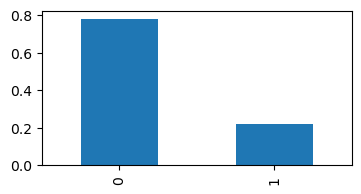

In [9]:
# Outcome prevalence
counts = df_raw[TARGET].value_counts(dropna=False)
prevalence_percent = counts[1] / counts.sum() * 100
positives_per_1000 = counts[1] / counts.sum() * 1000

print("Outcome counts:")
print(counts)
print(f"\nPrevalence: {prevalence_percent:.2f}%")
print(f"Patients who survived per 1000: {positives_per_1000:.1f}\n\n") 

plt.figure(figsize=(4,2))
df['survived'].value_counts(normalize=True).plot(kind='bar');


196004/890000 patients survived lung cancer, which is ~22.02% (barely 1/5th) of patients logged in this dataset. 

For our next steps, this distribution of the classes (extremely unbalanced) means we will need to correct our imbalance through resampling strategies by either oversampling (SMOTE) or undersampling non-survivors in order to balance (but this would result in informaiton loss, so best not). Depending on the future model used, we could also explore adjusting class weights and ensure we are utilizing specific metrics (f1, roc, recall). 

In [27]:
df_female = df[df['gender'] == 0]
df_male = df[df['gender']== 1]
print(df_female.shape)
print(df_male.shape)


(444866, 22)
(445134, 22)


### 4.5.2 Univariate Analysis


#### Continuous Variables

**Age**

Most of our patients are wihtin 48-62 years old (25-75%), with the average patient being 55.0. The youngest patient is 4 and the oldest was 104, meaning this data is likely very skewed as the majority of the patients are within 40-75 years but there are a few extreme outliers. This indicates that the presence of younger patients are rare and can point to data anomalies. 

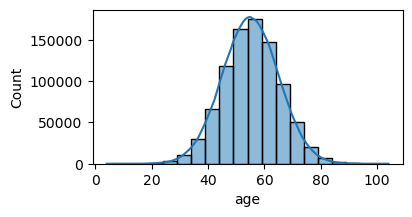

In [10]:
plt.figure(figsize=(4,2))
sns.histplot(df['age'], bins=20, kde=True);
plt.show()


**Female/Male Age**

The means and medians are nearly identical, around ~55 years, along with the distributions spread (within 48-62 range) and the quartiles. The extremes/outliers are barely different, with female 7-104 and male 4-101, which are all outliers. This indicates that age between the genders will do little to explain survival outcomes. 

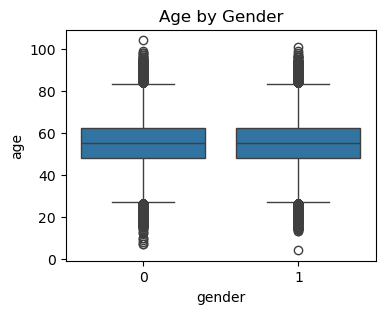

Female Age: 
count    444866.000000
mean         55.016457
std           9.996612
min           7.000000
25%          48.000000
50%          55.000000
75%          62.000000
max         104.000000
Name: age, dtype: float64

Male Age: 
count    445134.000000
mean         54.997565
std           9.992360
min           4.000000
25%          48.000000
50%          55.000000
75%          62.000000
max         101.000000
Name: age, dtype: float64


In [42]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='age', data=df); 
plt.title('Age by Gender')
plt.show()


print(f"Female Age: \n{df_female['age'].describe()}\n")
print(f"Male Age: \n{df_male['age'].describe()}")

**BMI**

The BMI of most patients is 23-37.7 (25-75%), with the average BMI being 30.4. The lower score is 16 while the higest score is 45. This data is more concentrated, with the average patient being overweight to obese, but this is to be expected as the range itself is normally within 18.5-40 (from underweight to class 3 obesity). A higher BMI is also an indicator of other risks, such as hypertension or diabetes, which would worsed the lung cancer prognosis. 

A more in depth analysis of BMI for women vs men should be done, as these values will signify different levels of BMI in different genders.

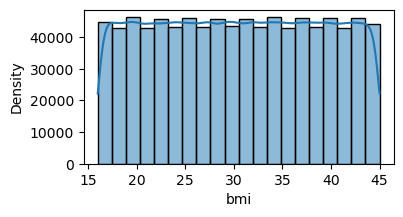

In [38]:
plt.figure(figsize=(4,2))
plt.ylabel('Density')
sns.histplot(df['bmi'], bins=20, kde=True);
plt.show() 

**Female/Male BMI**

The means and medians for both genders are nearly identical (~30.5), so overall the distributions (including the spread, quartiles) for BMI are nearly the same. This still indicates that regardless of gender, patients are overweight to obese. There is no strong gender difference when it comes to BMI, so this will not assist with explain gender specific survival differences.  

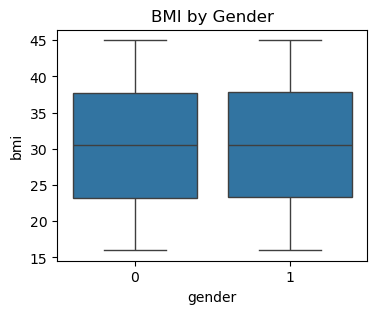

Female BMI: 
count    444866.000000
mean         30.489951
std           8.369305
min          16.000000
25%          23.200000
50%          30.500000
75%          37.700000
max          45.000000
Name: bmi, dtype: float64

Male BMI: 
count    445134.000000
mean         30.498389
std           8.367781
min          16.000000
25%          23.300000
50%          30.500000
75%          37.800000
max          45.000000
Name: bmi, dtype: float64


In [41]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='bmi', data=df); 
plt.title('BMI by Gender')
plt.show()


print(f"Female BMI: \n{df_female['bmi'].describe()}\n")
print(f"Male BMI: \n{df_male['bmi'].describe()}")

**Cholesterol Level**

The cholesterol levels of patients is within 196-271% (25-75%), with the average level being 233.63. This data reveals that the average person diagnosed with lung cancer has above average cholesterol levels, as a desirable level is less than 200mg/dL and high levels are 200-239 mg/dL -- yet the majority of our patient pool is between 196-271 (highest being 300 and lowest being 150), signifying there could be a correlation between high cholesterol and a lung cancer diagnosis. 

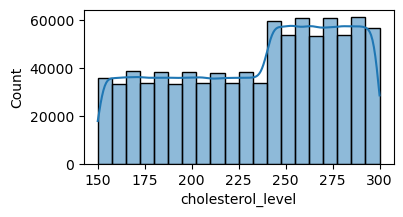

In [12]:
plt.figure(figsize=(4,2))
sns.histplot(df['cholesterol_level'], bins=20, kde=True);
plt.show() 

**Female/Male Cholesterol**

Once again, medians (242) and means (~233.6) are nearly identical between the genders, along with the spread (std=43), quartiles (196-271 mg/dL, with some extremes from 150-300). This indicates that again, regardless of gender, most patients are above the recommended level. 

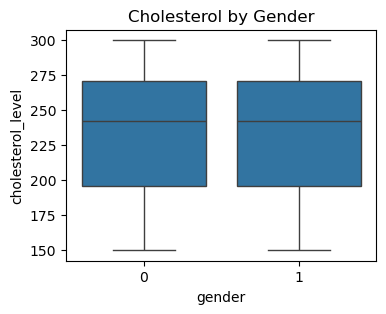

Female Cholesterol: 
count    444866.000000
mean        233.624183
std          43.445918
min         150.000000
25%         196.000000
50%         242.000000
75%         271.000000
max         300.000000
Name: cholesterol_level, dtype: float64

Male Cholesterol: 
count    445134.000000
mean        233.643642
std          43.418688
min         150.000000
25%         196.000000
50%         242.000000
75%         271.000000
max         300.000000
Name: cholesterol_level, dtype: float64


In [44]:
plt.figure(figsize=(4,3))
sns.boxplot(x='gender', y='cholesterol_level', data=df); 
plt.title('Cholesterol by Gender')
plt.show()


print(f"Female Cholesterol: \n{df_female['cholesterol_level'].describe()}\n")
print(f"Male Cholesterol: \n{df_male['cholesterol_level'].describe()}")

#### Binary Variables



This graph reveals the prevelance of 1's (yes's) within our data set for hypertension, family history (of cancer), asthma, cirrhosis, survived, and other cancers (being detected ontop of lung cancer). We will discuss gender and survived, seperately.

**Hypertension**

667521 out of 890000 (75%) of patients diagnosed with lung cancer also had hypertension (high blood pressure), which is another serious health issue. This typically follows a life of bad diets, minimal exersise, or simply genetics/age. This much higher than hypertension prevelance in Europe (30-45% of adults), which is consistent with lung cancer patients being older with other risk factors. This reinforces that cardiovascular risks are more common in lung cancer patients in Europe. 

**Family History**

444819 out of 890000 (49.97%) of patients had a existing family history of cancer. This is still quite high, indicating genetic predispositions (and potentially better record keeping of medical records within healthcare systems/family records, which can vary from region to region). 

**Asthma**

418069 out of 890000 (46.97%) of patients had a diagnosis of asthma (another lung/breathing disorder). This is much higher than the overall prevelance of asthma in Europe, which is only 5-10% of the general population. This shows a strong correlation between chronic respiratory conditions and a risk of lung cancer. It could also be likely that patients already diagnosed with asthma were already getting more frequent checkups, allowing for the detection of lung cancer to be more likely. 

**Cirrhosis**

201101 our of 890000 (22.59%) of patients have cirrhosis, which is a condition that scars and damages the liver (leads to hypertension, blocks ability to filter toxisn/process nutrients/produce bile/etc.). Considering Europe, especially central/eastern regions, are already facing some of the highest cirrhosis rates globally due to alcohol consumption, this follows the same track that LC patients would also face an increased likelihood of a diagnosis. This is also very clinically significant as cirrhosis will reduce tolerance to chemotheray. 

**Other Cancer** 
78460 out of 890000 (8.81%) of patients had another diagnosis for cancer (ontop of lung cancer). Considering Europe has an ageing population and a high long-term smoking population, indicating cancer rates will increase in likelihood. 


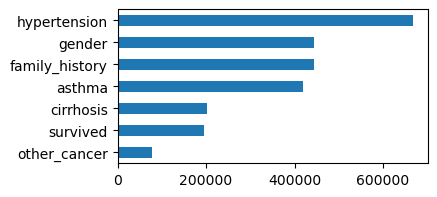

In [13]:
plt.figure(figsize=(4,2))
df[binary_cols].sum().sort_values().plot(kind='barh');
plt.show()

In [14]:
for col in binary_cols:
    if col == "gender" or col == "survived":
        continue
    else:
        counts = df_raw[col].value_counts(dropna=False)
        prevalence_percent = counts[1] / counts.sum() * 100
        positives_per_1000 = counts[1] / counts.sum() * 1000
        print(f"{col}: \n{counts}\nPrevalence %: {prevalence_percent}\nPositives per 1000: {positives_per_1000}\n\n")



family_history: 
No     445181
Yes    444819
Name: family_history, dtype: int64
Prevalence %: 49.979662921348314
Positives per 1000: 499.7966292134832


hypertension: 
1    667521
0    222479
Name: hypertension, dtype: int64
Prevalence %: 75.00235955056179
Positives per 1000: 750.0235955056179


asthma: 
0    471931
1    418069
Name: asthma, dtype: int64
Prevalence %: 46.974044943820225
Positives per 1000: 469.74044943820223


cirrhosis: 
0    688899
1    201101
Name: cirrhosis, dtype: int64
Prevalence %: 22.59561797752809
Positives per 1000: 225.9561797752809


other_cancer: 
0    811540
1     78460
Name: other_cancer, dtype: int64
Prevalence %: 8.815730337078652
Positives per 1000: 88.15730337078652




#### Categorical Variables

**Smoking Status**

The dataset split almost evenly in 4 for passive smoking (25.07%), never smoked (25.02%), former smoker (24.96%), and current smoker (24.93%). 

**Treatment Type** 

The same goes for treatment type, with chemotherapy (25.08%), surgery (25.08%), combined (25.01%), and radiation (24.81%). 

In [18]:
for col in ['smoking_status', 'treatment_type']:
    counts = df_raw[col].value_counts(dropna=False)
    prevalence_percent = (counts / counts.sum()) * 100
    positives_per_1000 = (counts / counts.sum()) * 1000
    print(f"{col}:\n{counts}\n\nPrevalence %:\n{prevalence_percent}\n\nPositives per 1000:\n{positives_per_1000}\n\n")


smoking_status:
Passive Smoker    223170
Never Smoked      222751
Former Smoker     222181
Current Smoker    221898
Name: smoking_status, dtype: int64

Prevalence %:
Passive Smoker    25.075281
Never Smoked      25.028202
Former Smoker     24.964157
Current Smoker    24.932360
Name: smoking_status, dtype: float64

Positives per 1000:
Passive Smoker    250.752809
Never Smoked      250.282022
Former Smoker     249.641573
Current Smoker    249.323596
Name: smoking_status, dtype: float64


treatment_type:
Chemotherapy    223262
Surgery         223261
Combined        222609
Radiation       220868
Name: treatment_type, dtype: int64

Prevalence %:
Chemotherapy    25.085618
Surgery         25.085506
Combined        25.012247
Radiation       24.816629
Name: treatment_type, dtype: float64

Positives per 1000:
Chemotherapy    250.856180
Surgery         250.855056
Combined        250.122472
Radiation       248.166292
Name: treatment_type, dtype: float64




### 4.5.3 Bivariate Analysis


#### Continuous vs Target

**Here we are asking if survivors have different average values than the non suvivors.**

To analyze any influence from the continuous variables on the target feature, we will be 
- Analyzing summary stats between the distribution of continuous variables between survivors and non-survivors. 
- Visualizing them through box plots to see the distributional differences
- Performings statistical tests: t-test (compares means, assumes equal variance/normality) and mann whitney tests (non parametric, tests distribution shift)
- Performing Cohen's d to determine effect size for mean differences 

**Survival vs Age**

There appears to be minimal relationship between age and survival rates, as the means are both ~55.0 and the both of the medians are 55.0, along with the quartiles (middle 50%) both being 42-62 years, which aligns with lung cancer being more commonafter 45. The one difference is the non-survivor gropu had patients as young as 4 and as old as 104, while the survivor group was within the range of 10-101 years. 

In the statistical tests below, the mean age differs by around ~0.03 years (essentially no difference), the t-test p=0.244 and mann-whitney u test p= 0.141 (both >0.05) show no statistically different difference, and the cohen's d= 0.003 shows a negligable effective size. Again, it is proven that survivors/non-survivors are essentially the same age on avergae. 

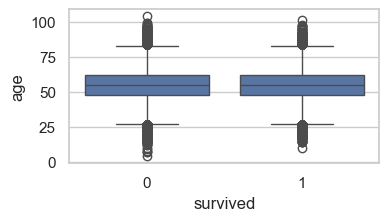

In [88]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='age', data=df);
plt.show()

In [20]:
print(df.groupby('survived')['age'].describe())


             count       mean       std   min   25%   50%   75%    max
survived                                                              
0         693996.0  55.000457  9.998431   4.0  48.0  55.0  62.0  104.0
1         196004.0  55.030203  9.980488  10.0  48.0  55.0  62.0  101.0


In [ ]:
group0 = df[df["survived"] == 0]['age'].dropna()
group1 = df[df["survived"] == 1]['age'].dropna()


def cont_tests(group0, group1):     #this will be reused for all continuous vars     
    results = []
    #assumes equal variance, looking for p<0.05
    t_stat, t_p = ttest_ind(group0, group1, equal_var=True)
    #mannwhitney test, tests distribution shifts, p<0.05 
    u_stat, u_p = mannwhitneyu(group0,group1, alternative="two-sided")   

    #cohens d, tests for effect size for mean diff (0.2=small, 0.5=meduim, 0.8=large)
    mean_diff = group1.mean()-group0.mean()
    pooled_std = np.sqrt(((len(group0)-1)*group0.std()**2 + (len(group1)-1)*group1.std()**2) /(len(group0)+len(group1)-2))
    cohen_d = mean_diff / pooled_std  

    
    results.append({
        "variable": col,
        "group0_mean": group0.mean(), "group1_mean": group1.mean(),
        "t-test_p": t_p,
        "mw_p": u_p,       #mann whitney
        "cohen_d": cohen_d
    })

    return results

bivar_age_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_age_results)



       variable  group0_mean  group1_mean  t-test_p      mw_p   cohen_d
0  other_cancer    55.000457    55.030203  0.244597  0.141017  0.002976


**BMI vs Surivived**

Mean/median BMI are nearly identical for both suvivors and non survivors (~30.49-30.5), with the spread (8.37) and quartiles being virtually the same too. This indicates that BMI alone will not explain survival outcomes but we can consider the implications of a higher BMI (which is shown in our average patient) to be side effects such as hypertension and high cholesterol. 

In the statistical tests below, the mean BMI differs by around ~0.0001 (so, no difference as this is 0 in practical terms), the t-test p=0.994 and mann-whitney u test p= 0.994 (both >0.05 and basically ~1) show no statistically different difference, and the cohen's d= 0.000016 shows no effect. Again, it is proven BMI has no relationship to survival in this dataset. 


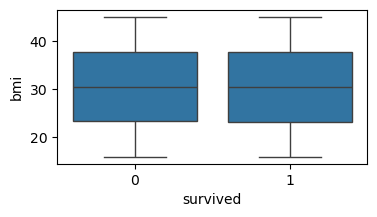

In [ ]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='bmi', data=df);
plt.show()

In [22]:
print(df.groupby('survived')['bmi'].describe())

             count       mean       std   min   25%   50%   75%   max
survived                                                             
0         693996.0  30.494141  8.368874  16.0  23.3  30.5  37.7  45.0
1         196004.0  30.494278  8.367376  16.0  23.2  30.5  37.7  45.0


In [85]:
group0 = df[df["survived"] == 0]['bmi'].dropna()
group1 = df[df["survived"] == 1]['bmi'].dropna()

bivar_bmi_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_bmi_results)

       variable  group0_mean  group1_mean  t-test_p    mw_p   cohen_d
0  other_cancer    30.494141    30.494278  0.994904  0.9943  0.000016


**Cholesterol vs Survived**

Again, there is minimal difference between the means/medians of cholesterol levels (233.63, 242), the spread (std=43), and the quartiles (between 196-271 mg/dL) in regard to suviving. While both survivors and non suvivors had elevated levels of cholesterol but cholesterol levels alone will not determine survival outcomes in the dataset. 

In the statistical tests below, the mean cholesterol differs by around ~0.016 points (nothing meaningful), the t-test p=0.882 and mann-whitney u test p= 0.923 (both >0.05) show no statistically different difference, and once again the cohen's d= 0.0004 shows no effect. Again, it is proven cholesterol has no relationship to survival in this dataset. 


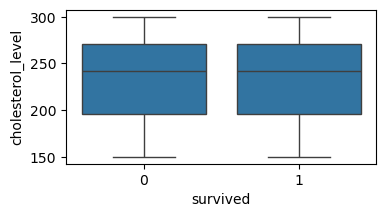

In [ ]:
plt.figure(figsize=(4,2))
sns.boxplot(x='survived', y='cholesterol_level', data=df);
plt.show()

In [47]:
print(df.groupby('survived')['cholesterol_level'].describe())

             count        mean        std    min    25%    50%    75%    max
survived                                                                    
0         693996.0  233.630285  43.434564  150.0  196.0  242.0  271.0  300.0
1         196004.0  233.646773  43.424290  150.0  196.0  242.0  271.0  300.0


In [86]:
group0 = df[df["survived"] == 0]['cholesterol_level'].dropna()
group1 = df[df["survived"] == 1]['cholesterol_level'].dropna()

bivar_chol_results = pd.DataFrame(cont_tests(group0, group1))
print(bivar_chol_results)

       variable  group0_mean  group1_mean  t-test_p      mw_p  cohen_d
0  other_cancer   233.630285   233.646773  0.882018  0.923347  0.00038


#### Binary vs Target

**Here we are asking if survival rates differ between different groups**

To analyze any influence from the binary variables on the target feature, we will be 
- Computing survival rates for each group 0/1
- Adding confidence intervals to show uncertainity. 
- Performing the statistical test, Chi-squared test


**Gender vs Survival**

The differences between gender and survival (21.99-22.05% between male/female) indicates there is minimal influence of gender on survival. The p value is > 0.05 so this indicates that this feature does not show a statistically significant assosication with survival in this dataset. 

**Family History vs Survival**

Again, there is little difference having or not between a family history of cancer and survival (21.9-22.07%) and the p value being >0.05 shows us no statistically significant assosication with survival in this dataset. 

**Hypertension vs Survival**

There is no difference between having or not hypertension on survival (22.2%), and with a p value of =.958 (>0.05), we can conclude there is no statistically significant assosication with survival and hypertension in this dataset.

**Asthma vs Survival**

There is still minimal differences between having or not having asthma on survival rate (21.94-22.02%) and while the p value is closer to 0.05, it is still p=0.088, high enough to indicate no statistically significant assosication with survival and asthma in this dataset. 

**Cirrhosis vs Survival**

There is minimal different between having/not having cirrhosis and survival (21.98-22.17%), with the p value still >0.05 (0.066) showing us, once again, no statistically significant assosication with survival in this dataset. 


**Other Cancer vs Survival**

There is minimal different between having/not having another type of cancer diagnosis and survival (21.76-22.05%), with the p value still >0.05 (0.064), indicating no statistically significant assosication between survival and other cancer dianosis in this dataset. 


**OVERALL**
None of the binary variables are showing much influence on survival rates, indicating we should be focusing either more on continous variables (BMI/cholesterol), treatment types, or potential combinations of features/interactions between variables. 


['gender', 'family_history', 'hypertension', 'asthma', 'cirrhosis', 'other_cancer']
gender survival rates (%):
gender
0    21.991341
1    22.054482
Name: survived, dtype: float64
gender: p-value = 0.4739

family_history survival rates (%):
family_history
0    21.968143
1    22.077744
Name: survived, dtype: float64
family_history: p-value = 0.2131

hypertension survival rates (%):
hypertension
0    22.018707
1    22.024326
Name: survived, dtype: float64
hypertension: p-value = 0.9582

asthma survival rates (%):
asthma
0    22.093484
1    21.943268
Name: survived, dtype: float64
asthma: p-value = 0.0884

cirrhosis survival rates (%):
cirrhosis
0    21.979129
1    22.172938
Name: survived, dtype: float64
cirrhosis: p-value = 0.0655

other_cancer survival rates (%):
other_cancer
0    22.048328
1    21.760133
Name: survived, dtype: float64
other_cancer: p-value = 0.0635



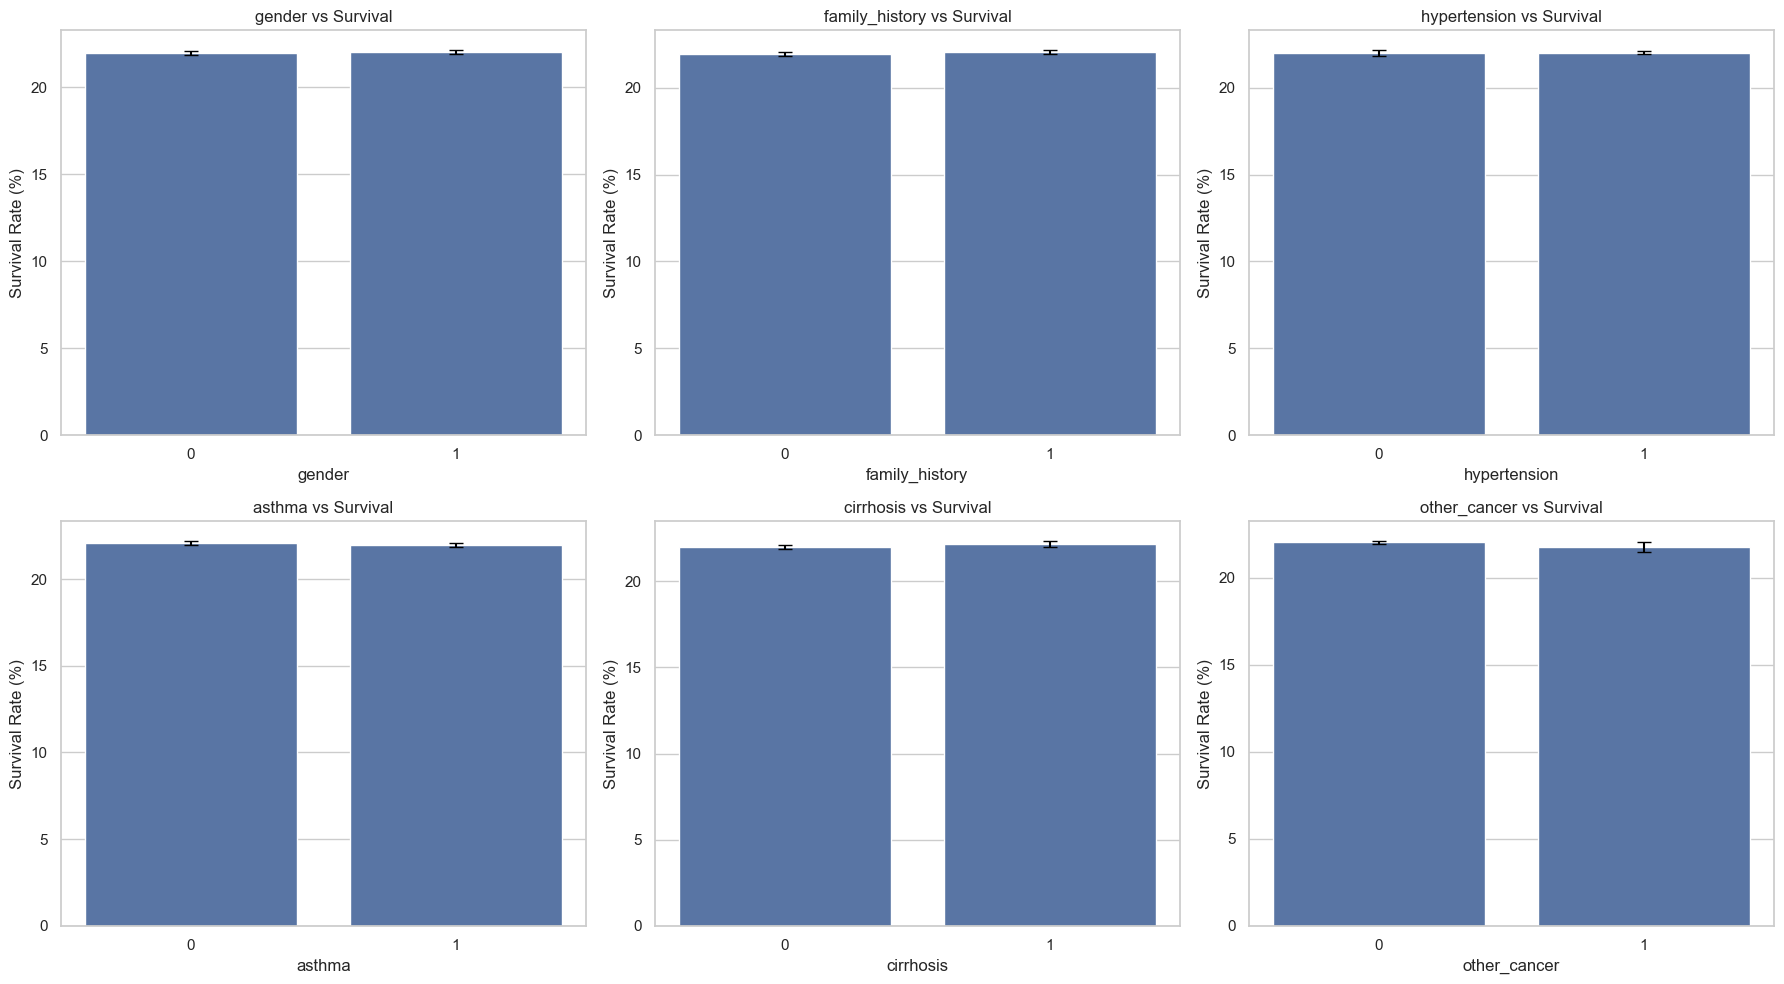

In [ ]:
binary_cols_1 = [col for col in binary_cols if col != "survived"]
print(binary_cols_1)      #removing surivived as it adds no significance here (we would be comparing it with itself)


for col in binary_cols_1:
    rates = df.groupby(col)['survived'].mean() * 100    #
    print(f"{col} survival rates (%):\n{rates}")      

    table = pd.crosstab(df[col], df['survived'])    #builds contingency table
    chi2, p, dof, ex = chi2_contingency(table)       #chi squared test - p values
    print(f"{col}: p-value = {p:.4f}\n")


#prints graphs to confirm our insights above: these binary features have minimal influence on survival rates

results = []
for col in binary_cols_1:
    grouped = df.groupby(col)["survived"].agg(['mean','count','sum'])  
    
    #add confidence intervals to show uncertainity around our estimate 
    for val, row in grouped.iterrows():
        ci_low, ci_high = proportion_confint(count=row['sum'], nobs=row['count'], method='wilson')
        
        results.append({
            "feature": col,     
            "group": val,
            "survival_rate":row['mean']* 100,
            "ci_low": ci_low* 100,
            "ci_high": ci_high*100    
        })    


binary_plot_df = pd.DataFrame(results)    #temporary df for analyzing these results
fig, axes = plt.subplots(2,3, figsize=(18,10))  
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()


for i, feature in enumerate(binary_cols_1):
    sub = binary_plot_df[binary_plot_df['feature'] == feature]
    sns.barplot(x="group", y="survival_rate", data=sub, ax=axes[i])
    
    #adds error bars: 
    axes[i].errorbar(x=np.arange(len(sub)), y=sub['survival_rate'],
                     yerr=[sub['survival_rate']- sub['ci_low'], sub['ci_high']-sub['survival_rate']],
                     fmt='none', c='black', capsize=5);
    
    axes[i].set_title(f"{feature} vs Survival"),
    axes[i].set_ylabel("Survival Rate (%)");
    axes[i].set_xlabel(feature);

plt.tight_layout()
plt.show();  



#### Categorical vs Target

**Here we are asking if survival rates differ between different groups**

To analyze any influence from the categorical variables on the target feature, we will
- Calculate survival rates per category 
- Add confidence intervals to determine uncertainity 
- Visualize the differences 
- Perform the statistical test, chi-squared test of independence 

**Smoking Status vs Survival**

In the calculated survival rates per category, they are all almost equal, within 21.96-22.09%, showing tiny differences in survival rates. The chi squared p value = 0.772 (>0.05) shows no significant differences in survival across smoking status. The graphs done below confirm this to us. 

Smoker Status Summary:
0    0.220340
1    0.219641
2    0.220910
3    0.220025
Name: survival_rate, dtype: float64


Smoking status vs survival: p=0.7722926422184736


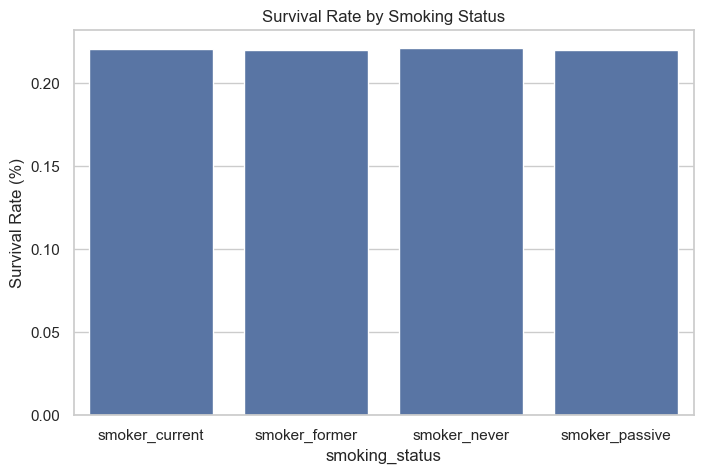

In [ ]:
smoking_cols = [c for c in df.columns if "smoker_" in c]
df["smoking_status"] = df[smoking_cols].idxmax(axis=1).str.replace("smoking_status_", "")
smoking_summary = df.groupby("smoking_status")["survived"].agg(survival_rate="mean",count="count", survivors="sum").reset_index() 

pd.crosstab(df["smoking_status"], df["survived"])
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df["smoking_status"], df["survived"]))    #chi squared tets of independence 

print(f"Smoker Status Summary:\n{smoking_summary['survival_rate']}\n\n")
print(f"Smoking status vs survival: p={p}")


plt.figure(figsize=(8,5))
sns.barplot(
    x="smoking_status", y="survival_rate", 
    data=smoking_summary, 
    errorbar=('ci', 95)               #automatically computes 95% confidence intervals
)
plt.ylabel("Survival Rate (%)")
plt.title("Survival Rate by Smoking Status")
plt.show();

**Treatment Type vs Survival**

In the survival rates between treatment types, they range between 21.87-22.15%, with an almost equal value for each category. The chi-squared p value = 0.162 (>0.05) also shows no statisical difference between different types of treatment and survival (chemo/radiation/surgery/none). The graphs once again confirm this.


Treatment Type Summary:
0    0.218739
1    0.220126
2    0.220557
3    0.221499
Name: survival_rate, dtype: float64


Treatment type vs survival: p=0.1621055798959168


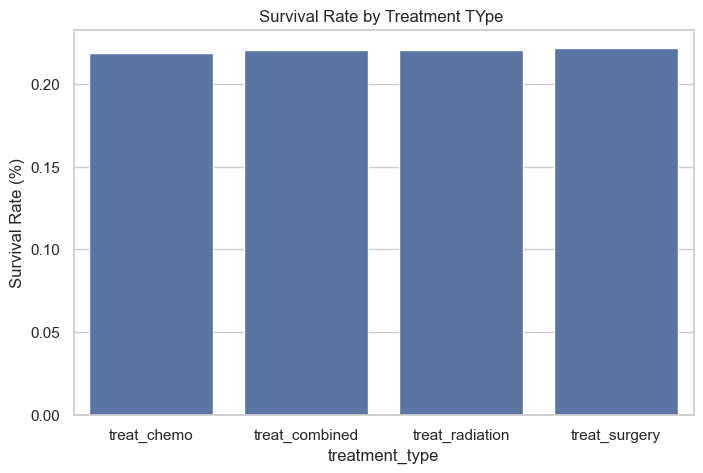

In [102]:
treatment_cols = [c for c in df.columns if "treat_" in c]
df["treatment_type"] = df[treatment_cols].idxmax(axis=1).str.replace("treatment_type_", "")  


treatment_summary= df.groupby("treatment_type")["survived"].agg(survival_rate="mean", count="count", survivors="sum").reset_index()

pd.crosstab(df["treatment_type"], df["survived"])
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df["treatment_type"], df["survived"]))

print(f"Treatment Type Summary:\n{treatment_summary['survival_rate']}\n\n")
print(f"Treatment type vs survival: p={p}")


plt.figure(figsize=(8,5))
sns.barplot(
    x="treatment_type", y="survival_rate", 
    data=treatment_summary, 
    errorbar=('ci', 95)               #automatically computes 95% confidence intervals
)
plt.ylabel("Survival Rate (%)")
plt.title("Survival Rate by Treatment TYpe ")
plt.show();


Considering that this is regarding treatment type and clearly receiving treatment or not is a huge factor in cancer survival. The reason this dataset is showing up little to no difference between treatment types is becausing this is considering survival to be 0/1, without the consideration of 
- length of survival after treatment type selected
- age, current health
- early/late stage diagnosis
- not all patients are eligable for each treatment (surgery would be for younger, healthier patients while late stage would be more likely to receieve chemotherapy). 

While this is good initial EDA, this should not discredit the influence treatment types or other variables with low statistical influence (up to this point). We need to consider more complex analysis. 

### 4.5.4 Multivariate Analysis

did not get far here, can someone else finish this one up? 

C:\Users\annap\AppData\Local\Temp\ipykernel_27304\2533626120.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2);


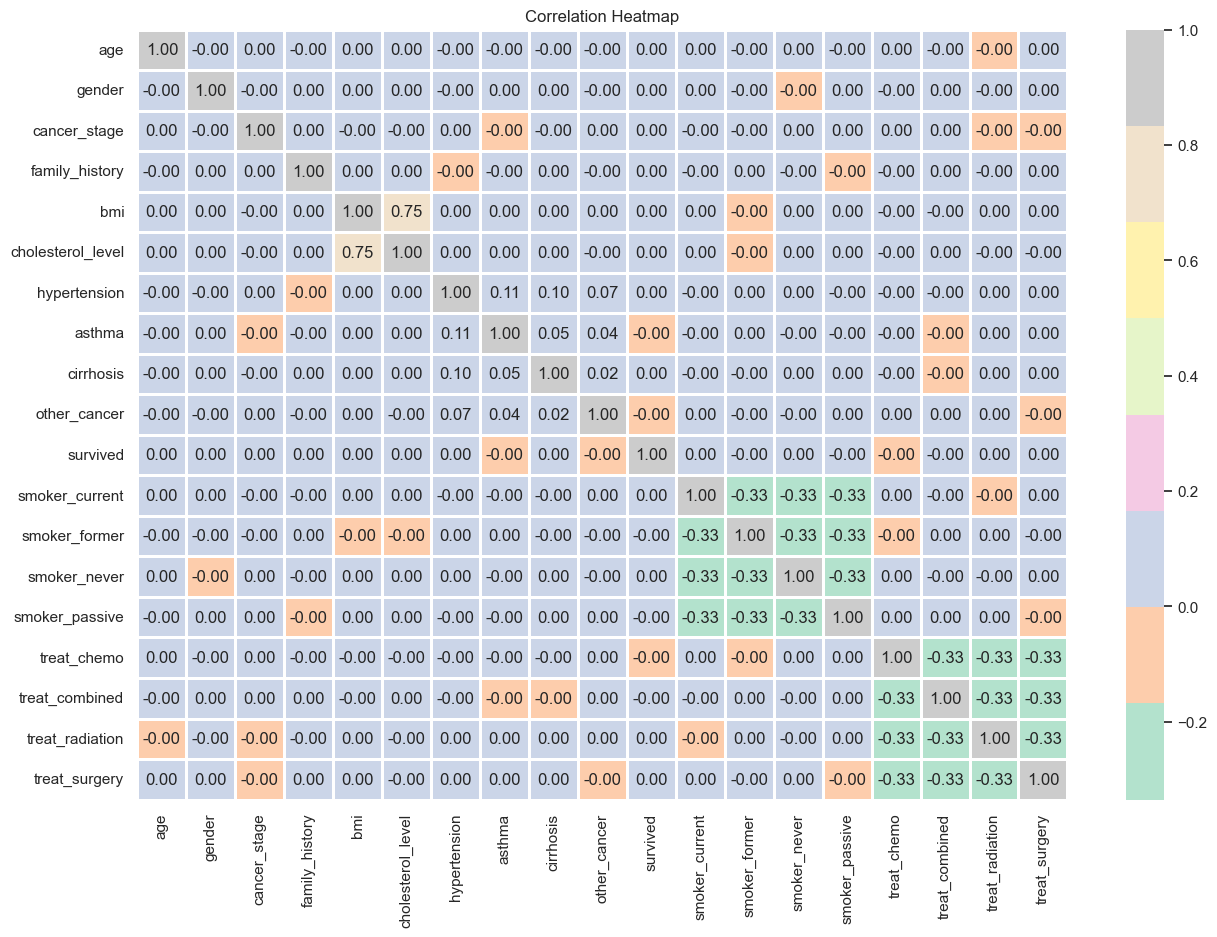

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2); 

plt.title('Correlation Heatmap')
plt.show()

### 4.5.5 Overall Takeaways

**After Univariate/Bivariate Analysis**

While the majority of these variables have little to no main influence over surivival rate, we should be considering a more depth exploration of their interactions. THIS IS NORMAL FOR MEDICAL DATASETS, ESPECIALLY WITH OUR IMBALANCE. We should consider interactions/combinations such as (not all though) to be more insightful
- treatment_type, age
- treatment_type, asthma/hypertension/cholesterol_level/cirrhosis 
- smoking_status, age
- smoking_status, asthma/hypertension/cholesterol_level/cirrhosis
- smoking_status, gender
- BMI, asthma/hypertension/cholesterol_level/cirrhosis
- cholesterol_level, age/gender
- other_cancer, treatment_type
- family_history, smoking_status
- hypertension/cirrhosis, treatment_type

**While we do have a decent amount of variables, we shouldn't drop any of them (unless absolutely necessary) as we would lose predictive power. We should consider regularization methods (lasso/ridge) to shrink the less important ones, or maybe a random forest/xgboost in order to rank variables before modeling.** 

We should also address our class imbalance before modeling as only 22% of our patients in the dataset survived, so we should either oversample or use class weighting when developing our model. 

# 5. Training, Validation and Testing - 80/15/5 stratified split

Train–test split

- Prevents “peeking” at data and overestimating performance
- Mimics real-world deployment where models face unseen patients
- Always evaluate on data not used for training

In [108]:
target_col = "survived"
num_cols = ["rx_ds"]
# num_cols = df.shape[1]
print(num_cols)
cat_like_binary_cols = binary_cols.copy()

X = df[num_cols + cat_like_binary_cols].copy()
y = df[target_col].copy()

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation and test, 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)
# Display shapes and class distributions as a DataFrame

info = {
    "Set": ["Train", "Validation", "Test", "Overall"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape, X.shape],
    "y shape": [y_train.shape, y_val.shape, y_test.shape, y.shape],
    "p(survived=0)": [
        y_train.value_counts(normalize=True).get(0, 0.0),
        y_val.value_counts(normalize=True).get(0, 0.0),
        y_test.value_counts(normalize=True).get(0, 0.0),
        y.value_counts(normalize=True).get(0, 0.0),
    ],
    "p(survived=1)": [
        y_train.value_counts(normalize=True).get(1, 0.0),
        y_val.value_counts(normalize=True).get(1, 0.0),
        y_test.value_counts(normalize=True).get(1, 0.0),
        y.value_counts(normalize=True).get(1, 0.0),
    ],
}

df_info = pd.DataFrame(info)
display(df_info.style.format({"p(survived=0)": "{:.3f}", "p(survived=1)": "{:.3f}"}))

['rx_ds']


KeyError: "['rx_ds'] not in index"

## 5.1. Modeling pipeline, training, and calibration

### Setting a baseline
A naive majority-class baseline clarifies the minimum standard any model must beat, highlighting the danger of ignoring minority patients and ensuring improvements carry meaningful weight in healthcare decision making

**ROC AUC**  
- 0.5 → no discrimination
- 0.6–0.7 → poor
- 0.7–0.8 → fair
- 0.8–0.9 → good
- ≥ 0.9 → excellent

**PR AUC**  
- Must be interpreted against event prevalence `p` in the validation set  

Dummy baseline
PR AUC: 0.180
ROC AUC: 0.500
Prevalence p = 0.180  |  PR AUC lift = 1.00× over baseline


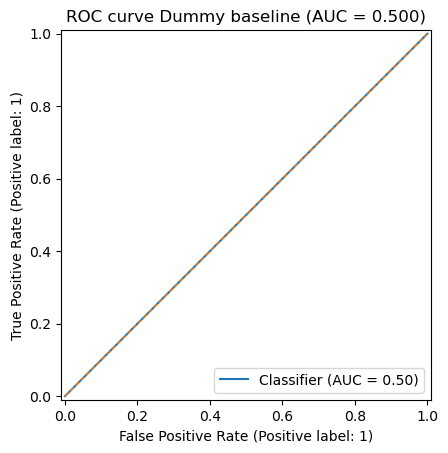

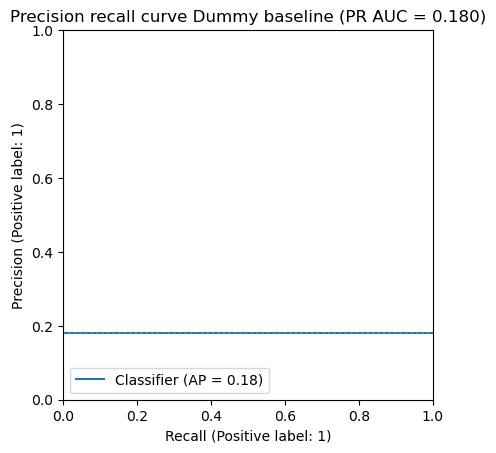

In [ ]:
# Baseline: DummyClassifier (majority class)
dummy_clf = DummyClassifier(
    strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

proba_val = dummy_clf.predict_proba(X_val)
pos_idx = int(np.where(dummy_clf.classes_ == 1)[0][0])  # index for class "1"
y_score_val = np.asarray(proba_val)[:, pos_idx]

# Evaluate on validation
y_score_val = positive_scores(dummy_clf, X_val)
metrics_dummy = auc_report(
    y_val, y_score_val, name="Dummy baseline", plot=True)

## 5.2. Preprocesing our Pipeline

[Scikit-learn preprocessing](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) standardizes and transforms features for modeling, including scaling, encoding, and imputation. Helping to maintain a consistent data transformation workflow

ADD LASSO REGULARIZATION HERE, AFTER SCALING/BINARY

In [ ]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, cat_like_binary_cols)
    ],
    remainder="drop",  # drops any column not in previously specified
    verbose_feature_names_out=False  # keeps original feature names
)

# Logistic Regression baseline with variance filter
base_clf = Pipeline(steps=[
    ("prep", preprocess),
    # Eliminates features with zero variance
    ("varth", VarianceThreshold(threshold=0.0)),
    ("model", LogisticRegression(
        solver="liblinear",  # See details in course material
        class_weight="balanced",  # Adjusts weights for class imbalance
        random_state=RANDOM_STATE,
        max_iter=200
    ))
])

### Basic preliminary model performance check

base_clf
PR AUC: 0.495
ROC AUC: 0.750
Prevalence p = 0.180  |  PR AUC lift = 2.75× over baseline


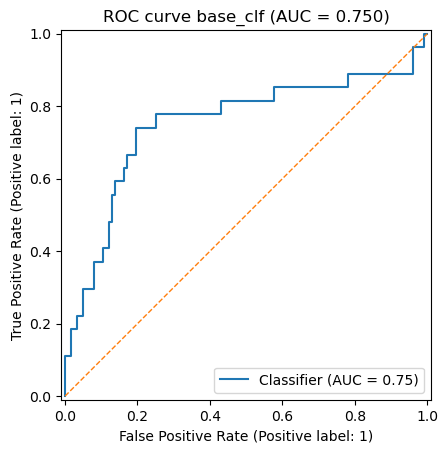

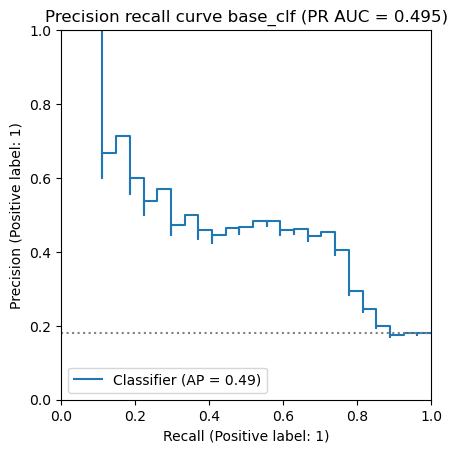

In [ ]:
# Fit base model
base_clf.fit(X_train, y_train)

# Evaluate on validation
y_score_val = positive_scores(base_clf, X_val)
metrics_base = auc_report(y_val, y_score_val, name="base_clf", plot=True)

In [ ]:
# Five patients: raw pre-calibration score, predicted label, actual label

tbl5 = (
    pd.DataFrame(
        {
            "raw_score": positive_scores(base_clf, X_val),            #raw scores = certainity that our predicted value is correct 
            "actual": y_val.loc[X_val.index].astype(int),
        },
        index=X_val.index,
    )
    .assign(predicted=lambda d: (d["raw_score"] >= 0.50).astype(int))  # threshold before calibration
    .round({"raw_score": 3})
    .sample(n=10, random_state=7)
    .reset_index()
    .rename(columns={"index": "patient"})
    .loc[:, ["patient", "raw_score", "predicted", "actual"]]
)

display(tbl5)


,patient,raw_score,predicted,actual
0,641,0.274,0,0
1,466,0.799,1,1
2,993,0.415,0,0
3,860,0.278,0,0
4,486,0.211,0,0
5,305,0.560,1,0
6,166,0.270,0,0
7,24,0.636,1,0
8,602,0.396,0,0
9,573,0.326,0,0


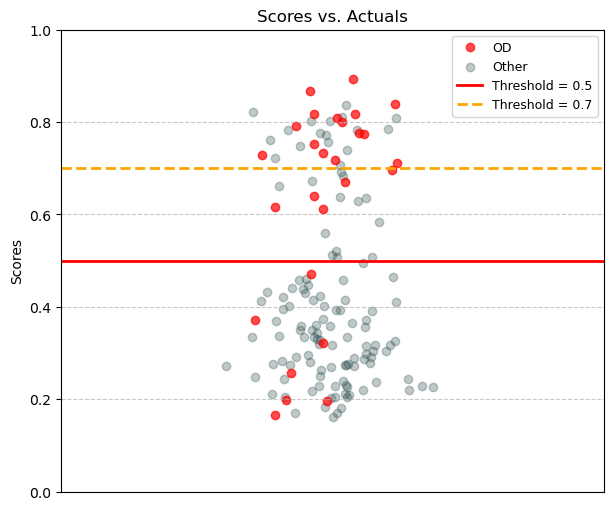

In [ ]:
# Data for the plot using variables from the preceding cells
scores = positive_scores(base_clf, X_val)
actuals = y_val

# Separate scores for actual positive (OD=1) and negative (OD=0) cases
scores_positive = scores[actuals == 1]
scores_negative = scores[actuals == 0]

# Generate random jitter for the x-axis
jitter_strength = 0.03
jitter_positive = np.random.normal(0, jitter_strength, len(scores_positive))
jitter_negative = np.random.normal(0, jitter_strength, len(scores_negative))

# 3. Create the plot
fig, ax = plt.subplots(figsize=(7, 6))
scatter_other = ax.scatter(jitter_negative, scores_negative, color='darkslategrey', alpha=0.3, label='Other')
scatter_target = ax.scatter(jitter_positive, scores_positive, color='red', alpha=0.7, label='OD')

# Add threshold lines
line_50 = ax.axhline(y=0.5, color='red', linestyle='-', linewidth=2, label='Threshold = 0.5')
line_80 = ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.7')

ax.set_title('Scores vs. Actuals')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlim(-0.2, 0.2) # Set fixed x-axis limits to control the visual spread
ax.legend(handles=[scatter_target, scatter_other, line_50, line_80], fontsize=9, loc='upper right')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. Recalibrating the Scores

**1. Reliable probabilities**  
- Turns raw scores into real probabilities  
- Ensures predictions match observed outcome frequencies  
- Prevents overly high or low risk estimates  

**2. Better clinical decisions**  
- Essential when risk values guide medical choices  
- Supports thresholds with clear clinical meaning
- Reduces wasted clinical resources  

**3. Trust and adoption**  
- Builds trust in AI decisions  
- Enables safer patient outcomes

In [ ]:
# Calibrate probabilities using CV on training data
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",
    cv=5
)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['rx_ds']),
                                                                                  ('bin',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                                   ['Low_inc',
                                                                                    'Surgery',
                                                                                    'A',
                                                                                    'B',
                                                                                    'C',
                                                                                    'D',
                                                                                    'E',
                                                                                    'F',
                                                                                    'H',
                                                                                    'I',
                                                                                    'J',
                                                                                    'K',
                                                                                    'L',
                                                                                    'M',
                                                                                    'N',
                                                                                    'R',
                                                                                    'S',
                                                                                    'T',
                                                                                    'V'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('varth', VarianceThreshold()),
                                                 ('model',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=200,
                                                                     random_state=42,
                                                                     solver='liblinear'))]))

,Risk_band,Patients,Avg_pred_before,Actual_OD_rate,Avg_pred_after
0,Q1,5,0.219,0.0,0.082
1,Q2,5,0.256,0.2,0.094
2,Q3,5,0.313,0.0,0.113
3,Q4,5,0.331,0.0,0.119
4,Q5,5,0.391,0.0,0.141
5,Q6,5,0.482,0.2,0.178
6,Q7,5,0.633,0.4,0.260
7,Q8,5,0.691,0.2,0.300
8,Q9,5,0.744,0.2,0.341
9,Q10,5,0.800,0.6,0.399


Check sizes
len(X_train) = 800 len(X_val) = 150 len(X_test) = 50
Rows in table sum to 50
Points near the diagonal mean predicted risk matches observed OD frequency


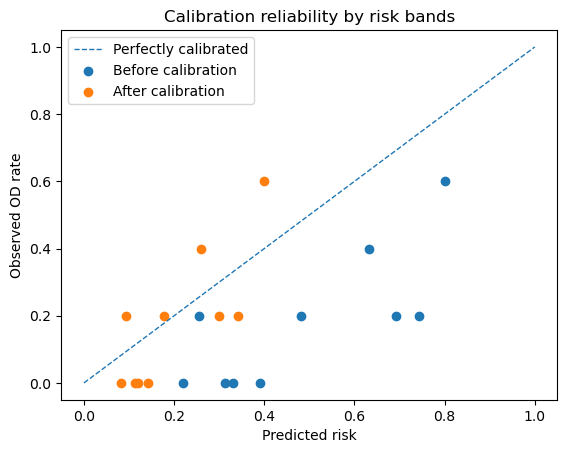

In [ ]:
# Quantile bands on test only
base_clf_uncal = clone(base_clf).fit(X_train, y_train)
p_before = base_clf_uncal.predict_proba(X_test)[:, 1]
p_after = calibrated_clf.predict_proba(X_test)[:, 1]

df_cal = pd.DataFrame({"Actual_OD": y_test.values, "Pred_before": p_before,
                      "Pred_after": p_after}, index=X_test.index)

# 10 quantile bands with similar counts
df_cal["Risk_band"] = pd.qcut(df_cal["Pred_after"], q=10, labels=[
                              f"Q{i}" for i in range(1, 11)], duplicates="drop")

summary = (
    df_cal.groupby("Risk_band", observed=True)
    .agg(Patients=("Actual_OD", "size"),
         Avg_pred_before=("Pred_before", "mean"),
         Actual_OD_rate=("Actual_OD", "mean"),
         Avg_pred_after=("Pred_after", "mean"))
    .reset_index()
    .round(3)
)
display(summary)

print("Check sizes")
print("len(X_train) =", len(X_train), "len(X_val) =",
      len(X_val), "len(X_test) =", len(X_test))
print("Rows in table sum to", int(summary["Patients"].sum()))

# Reliability plot using the same fixed risk bands summary
print("Points near the diagonal mean predicted risk matches observed OD frequency")
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--",
         linewidth=1, label="Perfectly calibrated")
plt.scatter(summary["Avg_pred_before"],
            summary["Actual_OD_rate"], label="Before calibration")
plt.scatter(summary["Avg_pred_after"],
            summary["Actual_OD_rate"],  label="After calibration")
plt.xlabel("Predicted risk")
plt.ylabel("Observed OD rate")
plt.title("Calibration reliability by risk bands")
plt.legend()
plt.show()

### Compare base_clf vs calibrated_clf on validation

In [ ]:
# Focus on discrimination equality and calibration improvements

# Scores
y_score_val_base = positive_scores(base_clf, X_val)
y_score_val_cal = positive_scores(calibrated_clf, X_val)

# Discrimination
roc_base = roc_auc_score(y_val, y_score_val_base)
pr_base = average_precision_score(y_val, y_score_val_base)
roc_cal = roc_auc_score(y_val, y_score_val_cal)
pr_cal = average_precision_score(y_val, y_score_val_cal)

# Calibration
ll_base = log_loss(y_val, np.clip(y_score_val_base, 1e-6, 1 - 1e-6))
ll_cal = log_loss(y_val, np.clip(y_score_val_cal,  1e-6, 1 - 1e-6))
brier_base = brier_score_loss(y_val, y_score_val_base)
brier_cal = brier_score_loss(y_val, y_score_val_cal)

# Assemble into dataframe
metrics_df = pd.DataFrame([
    {"Metric": "ROC AUC", "Base": roc_base, "Calibrated": roc_cal, "Explanation": "Ability to distinguish between classes (higher is better)"},
    {"Metric": "PR AUC", "Base": pr_base, "Calibrated": pr_cal, "Explanation": "Precision-recall curve area; useful for imbalanced data"},
    {"Metric": "Log loss", "Base": ll_base, "Calibrated": ll_cal, "Explanation": "Penalty for incorrect and overconfident predictions (lower is better)"},
    {"Metric": "Brier score", "Base": brier_base, "Calibrated": brier_cal, "Explanation": "Mean squared error of predicted probabilities (lower is better)"},
])

display(metrics_df.style.format({"Base": "{:.3f}", "Calibrated": "{:.3f}"}))

,Metric,Base,Calibrated,Explanation
0,ROC AUC,0.750,0.750,Ability to distinguish between classes (higher is better)
1,PR AUC,0.495,0.497,Precision-recall curve area; useful for imbalanced data
2,Log loss,0.589,0.400,Penalty for incorrect and overconfident predictions (lower is better)
3,Brier score,0.198,0.123,Mean squared error of predicted probabilities (lower is better)


# 7. Deciding where to cut off i.e. what probability is “high risk enough” to trigger an intervention?

,precision,recall,alerts_per_1000,true_pos_per_1000,FP,FN
threshold,,,,,,
0.1,0.204,0.852,753.333,153.333,90,4
0.2,0.435,0.741,306.667,133.333,26,7
0.3,0.485,0.593,220.000,106.667,17,11
0.4,0.600,0.222,66.667,40.000,4,21
0.5,1.000,0.037,6.667,6.667,0,26


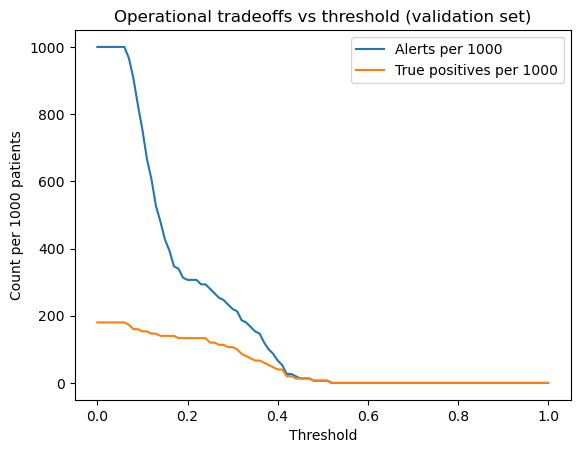

In [ ]:
# Get calibrated probabilities
y_score_val = positive_scores(calibrated_clf, X_val)

# Define a grid of thresholds
thresholds = np.linspace(0, 1, 101)
rows = []
for thr in thresholds:
    y_pred = (y_score_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    alerts_per_1000 = 1000 * np.mean(y_pred)
    true_pos_per_1000 = 1000 * tp / len(y_val)
    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "alerts_per_1000": alerts_per_1000,
        "true_pos_per_1000": true_pos_per_1000,
        "FP": fp,
        "FN": fn
    })

df_thr = pd.DataFrame(rows)

# Display a few candidate thresholds for discussion
display(
    df_thr.query("threshold in [0.1, 0.2, 0.3, 0.4, 0.5]")
         .round(3)
         .set_index("threshold")
)

# Plot workload vs threshold
plt.figure()
plt.plot(df_thr["threshold"], df_thr["alerts_per_1000"], label="Alerts per 1000")
plt.plot(df_thr["threshold"], df_thr["true_pos_per_1000"], label="True positives per 1000")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000 patients")
plt.title("Operational tradeoffs vs threshold (validation set)")
plt.legend()
plt.show()

## 7.1. Choosing an operating threshold

Models produce probabilities, but clinicians are the ones taking decisions, and carring the accountability of their actions.

- Setting a threshold balances in this case, among others, between missed addiction cases and unnecessary undertreatment of pain
- Clear rules make these tradeoffs explicit, explainable, and auditable!

We will run three threshold tuning analyses:
1. **Workload constrained threshold**  
  Capture the most true cases without exceeding a fixed alert capacity for the clinic
2. **Recall floor then maximize precision**  
  Guarantee a minimum case capture for safety, then pick the threshold with the fewest false alarms
3. **Cost based threshold (Bayes rule)**  
  Minimize expected harm using estimated costs for false negatives and false positives

Readouts to watch
- Threshold, precision, recall, alerts per 1000 patients, true positives per 1000, false positives, false negatives
- Connect the chosen rule to clinical policy and resource capacity

### 7.1.1. Workload constrained threshold for calibrated_clf on validation

- Alerts budget: maximum alerts per 1000 patients the clinic can review without overloading resources
- Objective: within the alerts budget, choose the threshold that yields the most true positives per 1000 so more patients at real risk are correctly flagged

In [ ]:
summary.head()

,Risk_band,Patients,Avg_pred_before,Actual_OD_rate,Avg_pred_after
0,Q1,5,0.219,0.0,0.082
1,Q2,5,0.256,0.2,0.094
2,Q3,5,0.313,0.0,0.113
3,Q4,5,0.331,0.0,0.119
4,Q5,5,0.391,0.0,0.141


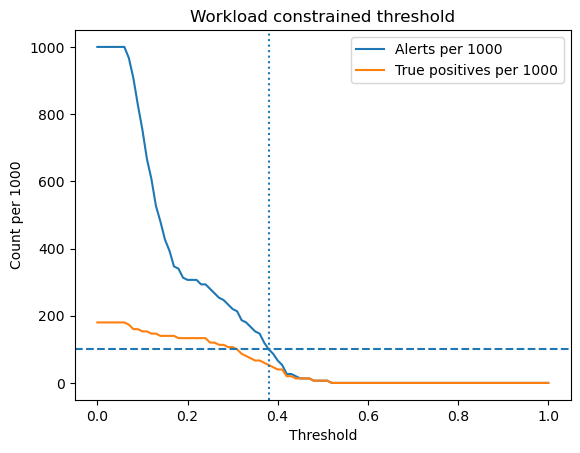

KeyError: "None of ['rule'] are in the columns"

In [ ]:
ALERTS_BUDGET = 100.0  # alerts per 1000 patients

y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
tbl = res["table"]

plt.figure()
plt.plot(tbl["threshold"], tbl["alerts_per_1000"], label="Alerts per 1000")
plt.plot(tbl["threshold"], tbl["true_pos_per_1000"], label="True positives per 1000")
plt.axhline(ALERTS_BUDGET, linestyle="--")
plt.axvline(res["threshold"], linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000")
plt.title("Workload constrained threshold")
plt.legend()
plt.show()

# put metrics in the rows, rules in the columns
pivot_df = summary.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# make sure summary_df is a DataFrame
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])


Let's now see the risk groups by decile (bands), and visualizes the overall risk score distribution, with optional threshold overlay and decile boundaries

,n,positives,min_score,max_score,prevalence,cum_capture,alerts_per_1000,true_pos_per_1000
band,,,,,,,,
1,15,8,0.381,0.520,0.533,0.296,100.0,53.333
2,15,5,0.316,0.378,0.333,0.481,100.0,33.333
3,15,7,0.229,0.316,0.467,0.741,100.0,46.667
4,15,1,0.159,0.221,0.067,0.778,100.0,6.667
5,15,1,0.135,0.156,0.067,0.815,100.0,6.667
6,15,0,0.121,0.134,0.000,0.815,100.0,0.000
7,15,1,0.106,0.120,0.067,0.852,100.0,6.667
8,15,1,0.097,0.105,0.067,0.889,100.0,6.667
9,15,0,0.083,0.093,0.000,0.889,100.0,0.000


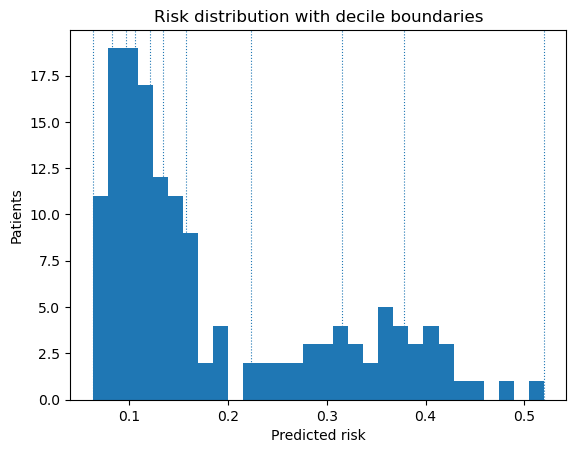

In [ ]:
N_BINS = 10  # deciles by default
y_score_val = positive_scores(calibrated_clf, X_val)

# Build bands by quantiles, highest risk = band 1
bands = pd.qcut(y_score_val, q=N_BINS, labels=False, duplicates="drop")
# qcut labels lowest=0..highest=K-1, invert so 1 is highest-risk band
bands = (bands.max() - bands) + 1

df = pd.DataFrame({
    "y_true": y_val.astype(int),
    "score": y_score_val,
    "band": bands.astype(int),
})

summ = (df.groupby("band", as_index=True)
          .agg(n=("y_true","size"),
               positives=("y_true","sum"),
               min_score=("score","min"),
               max_score=("score","max"))
          .sort_index())

summ["prevalence"] = summ["positives"] / summ["n"]
summ["cum_capture"] = summ["positives"].cumsum() / df["y_true"].sum()
summ["alerts_per_1000"] = 1000.0 * summ["n"] / len(df)
summ["true_pos_per_1000"] = 1000.0 * summ["positives"] / len(df)

display(summ.round(3))

# Optional threshold overlay if you already chose one, else set THR=None
THR = None  # e.g., THR = 0.23

# Histogram of risk scores with decile edges
plt.figure()
plt.hist(df["score"], bins=30)
if THR is not None:
    plt.axvline(THR, linestyle="--")
# draw decile boundaries
edges = np.quantile(df["score"], np.linspace(0,1,N_BINS+1))
for x in edges:
    plt.axvline(x, linestyle=":", linewidth=0.8)
plt.xlabel("Predicted risk")
plt.ylabel("Patients")
plt.title("Risk distribution with decile boundaries")
plt.show()


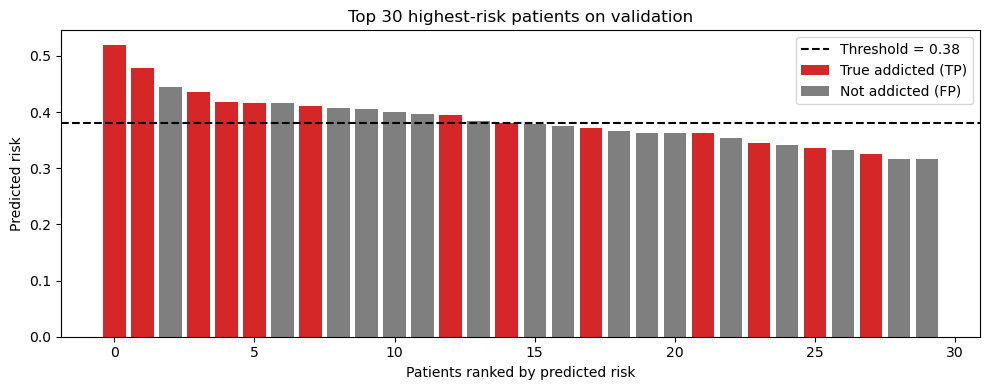

In [ ]:
THR = res["threshold"] # <- use the threshold from the previous step
y_score_val = positive_scores(calibrated_clf, X_val)
ids = np.arange(len(y_val))

# Sort patients by predicted risk
order = np.argsort(-y_score_val)
top_idx = order[:30]   # top 30 for visualization
top_scores = y_score_val[top_idx]
top_true = np.asarray(y_val)[top_idx].astype(int)

# Split indices for TP vs FP
tp_idx = np.where(top_true == 1)[0]
fp_idx = np.where(top_true == 0)[0]

plt.figure(figsize=(10, 4))
plt.bar(tp_idx, top_scores[tp_idx], color="tab:red", label="True addicted (TP)")
plt.bar(fp_idx, top_scores[fp_idx], color="tab:gray", label="Not addicted (FP)")
plt.axhline(THR, linestyle="--", color="black", label=f"Threshold = {THR:.2f}")

plt.xlabel("Patients ranked by predicted risk")
plt.ylabel("Predicted risk")
plt.title("Top 30 highest-risk patients on validation")
plt.legend()
plt.tight_layout()
plt.show()

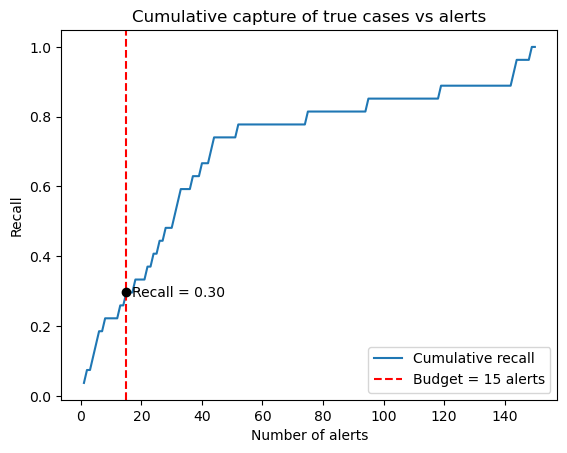

In [ ]:
y_score_val = positive_scores(calibrated_clf, X_val)
order = np.argsort(-y_score_val)
y_sorted = np.asarray(y_val)[order].astype(int)

# Cumulative recall
cum_tp = np.cumsum(y_sorted)
total_pos = cum_tp[-1] if cum_tp.size else 0
alerts = np.arange(1, len(y_sorted) + 1)
recall_curve = cum_tp / total_pos if total_pos > 0 else np.zeros_like(cum_tp)

# Budget for alerts
n_budget = int(np.ceil(ALERTS_BUDGET * len(y_val) / 1000.0))

# Recall at budget
recall_at_budget = recall_curve[n_budget - 1] if n_budget > 0 and n_budget <= len(y_val) else 0.0

# Plot
plt.figure()
plt.plot(alerts, recall_curve, label="Cumulative recall")
plt.axvline(n_budget, linestyle="--", color="red", label=f"Budget = {n_budget} alerts")

# Annotate recall at budget
plt.scatter(n_budget, recall_at_budget, color="black", zorder=5)
plt.text(n_budget + 2, recall_at_budget, f"Recall = {recall_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Recall")
plt.title("Cumulative capture of true cases vs alerts")
plt.legend()
plt.show()

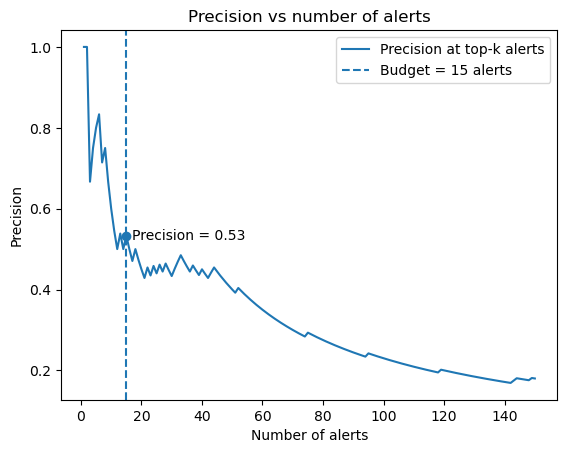

In [ ]:
# Cumulative precision at top-k alerts
alerts = np.arange(1, len(y_sorted) + 1)
cum_tp = np.cumsum(y_sorted)
precision_curve = cum_tp / alerts

# Alerts budget scaled to validation size
prec_at_budget = precision_curve[n_budget - 1] if 0 < n_budget <= len(y_sorted) else 0.0

# Plot
plt.figure()
plt.plot(alerts, precision_curve, label="Precision at top-k alerts")
plt.axvline(n_budget, linestyle="--", label=f"Budget = {n_budget} alerts")
plt.scatter(n_budget, prec_at_budget, zorder=5)
plt.text(n_budget + max(2, len(y_sorted)//100), prec_at_budget, f"Precision = {prec_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Precision")
plt.title("Precision vs number of alerts")
plt.legend()
plt.show()


### 7.1.2. Recall floor then maximize precision for calibrated_clf on validation

- Recall floor: minimum acceptable recall set by safety policy to limit missed addiction cases
- Precision objective: among thresholds meeting the recall floor, pick the one with highest precision to reduce unnecessary undertreatment and clinician workload

Deciding which recall floor to sue:
1. The chosen floor is a value judgment balancing patient safety vs resource burden
2. In medicine, it's often the case that missing a true case (false negative) is often much worse than raising extra alarms (false positives)
3. A recall floor enforces a safety guarantee: the model must capture at least e.g. 60% of patients who will become addicted

Among thresholds that satisfy recall ≥ 0.6, you then pick the one with the best precision, to minimize unnecessary undertreatment and workload

threshold,0.28
metric,
precision,0.459
recall,0.630
TP,17.000
FP,20.000
TN,103.000
FN,10.000
alerts_per_1000,246.667
true_pos_per_1000,113.333


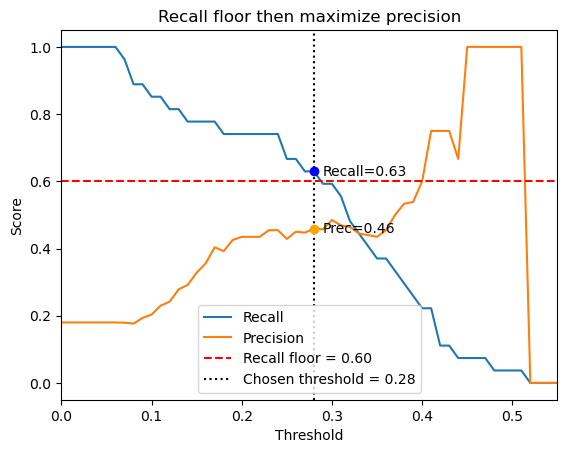

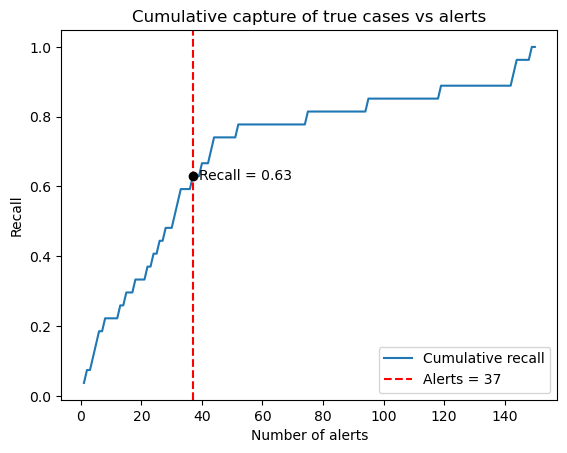

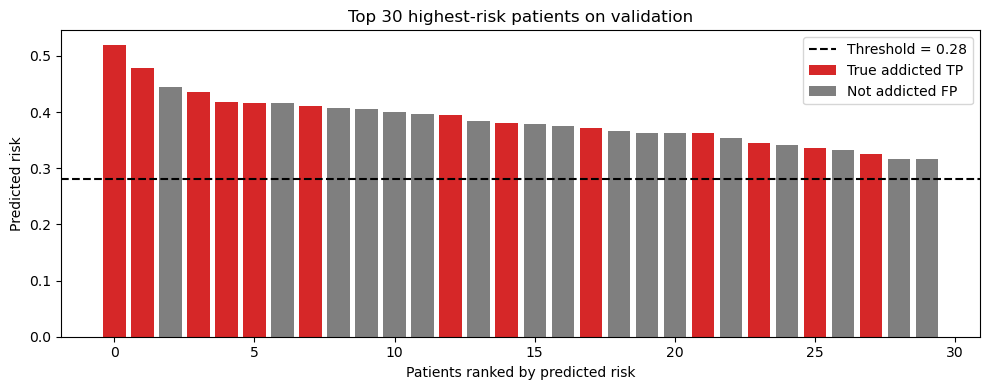

In [ ]:
# Step 1: choose threshold by recall floor
RECALL_FLOOR = 0.60 # <- judgment call
y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
THR = float(res["threshold"])

summary_df = summary_at_threshold(y_val, y_score_val, THR)
pivot_df = summary_df.set_index("threshold").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# Precision and recall vs threshold with annotations
plot_recall_floor_curves(y_val, y_score_val, recall_floor=RECALL_FLOOR, chosen_threshold=THR)

# Cumulative recall vs alerts with vertical line at alerts implied by THR
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)

# Patient-level prioritization view at THR
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)

### 7.1.3. Cost based threshold for calibrated_clf on validation

This approach selects a threshold that minimizes the expected cost of errors. We need to estimate the relative costs of false negatives (Givin opioid drugs to people who would actually get addited) and false positives (Depriving low risk people from receiving the medicine, costs in other terapies, etc.).

- Cost of a False Negative (C_FN): The cost of missing a patient who will develop an opioid use disorder (e.g., costs of future intensive treatment, overdose events, and negative health outcomes, social impact, etc.)

- Cost of a False Positive (C_FP): The cost of incorrectly flagging a patient as high-risk (e.g., costs of unnecessary clinical review, potential undertreatment of legitimate pain, and patient anxiety)

For this exercise, we will assume a cost ratio where a FN is 10 times more costly than a false positive. The optimal threshold is then found by minimizing the total expected cost (C_FP * FP + C_FN * FN) on the validation set

rule,Bayes formula,Empirical min cost
metric,,
threshold,0.090,0.170
precision,0.194,0.404
recall,0.889,0.778
TP,24.000,21.000
FP,100.000,31.000
TN,23.000,92.000
FN,3.000,6.000
alerts_per_1000,826.667,346.667
true_pos_per_1000,160.000,140.000


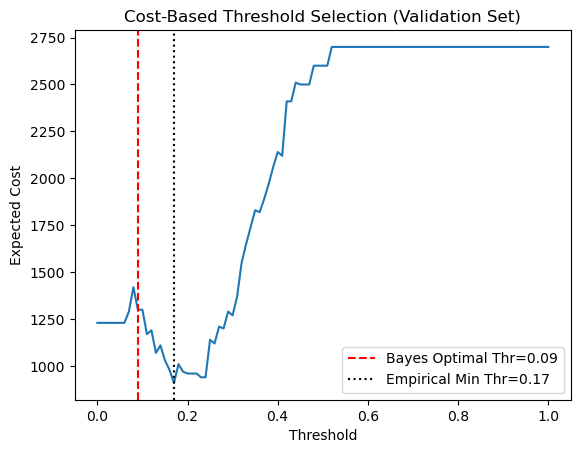

In [ ]:
# Set domain costs
C_FN = 100.0  # Cost of a missed addiction case (False Negative)
C_FP = 10.0   # Cost of undertreated pain (False Positive)

# Get scores from the calibrated model on the validation set
y_score_val = positive_scores(calibrated_clf, X_val)

# Find the optimal thresholds based on cost
res = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
tbl = res["table"].copy()
tbl["expected_cost"] = C_FP * tbl["FP"] + C_FN * tbl["FN"]

# Display a summary table comparing the two threshold options
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])

pivot_df = (
    summary_df.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Plot expected cost vs. threshold
plt.figure()
plt.plot(tbl["threshold"], tbl["expected_cost"])
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost-Based Threshold Selection (Validation Set)")

# Annotate the two optimal thresholds found
t_formula = res["threshold_formula"]
t_emp = res["threshold_empirical"]
plt.axvline(t_formula, linestyle="--", color="red", label=f"Bayes Optimal Thr={t_formula:.2f}")
plt.axvline(t_emp, linestyle=":", color="black", label=f"Empirical Min Thr={t_emp:.2f}")
plt.legend()
plt.show()


Visualizing performance at the empirical cost-based threshold of 0.170:


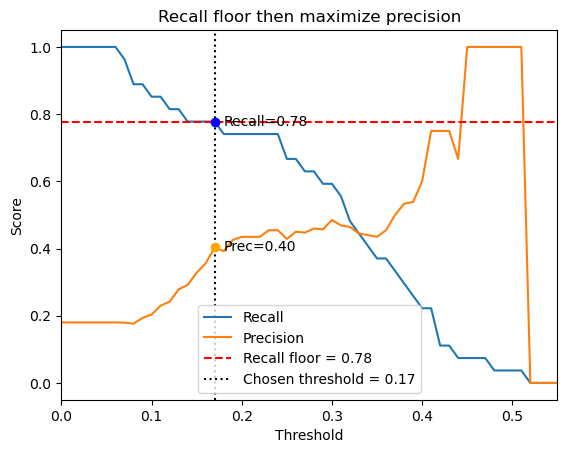

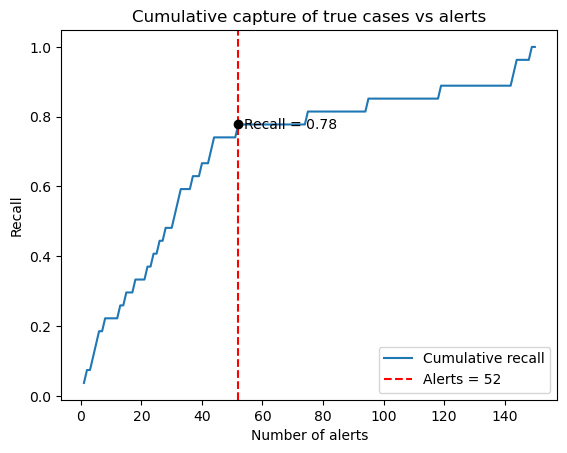

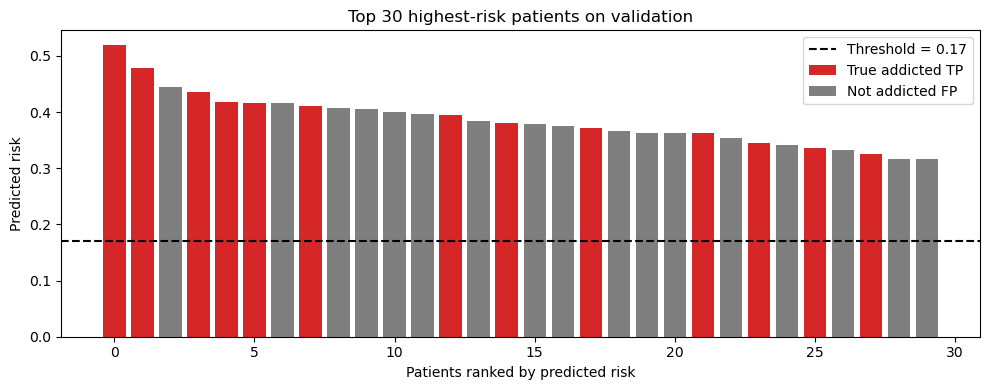

In [ ]:
# Get the empirically optimal threshold from the previous analysis
THR = res["threshold_empirical"]

# For visualization, we need a "recall_floor" to draw the horizontal line.
# We'll use the actual recall achieved at our chosen cost-based threshold.
y_pred_val = (y_score_val >= THR).astype(int)
recall_at_thr = recall_score(y_val, y_pred_val)

print(f"Visualizing performance at the empirical cost-based threshold of {THR:.3f}:")
plot_recall_floor_curves(y_val, y_score_val, recall_floor=recall_at_thr, chosen_threshold=THR)
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)


# 8. Final Threshold Selection and Test Set Evaluation

This is a crucial step that often involves discussion with clinical stakeholders to align the model's operating point with clinical goals, patient safety requirements, and resource availability

| Thresholding Method | Objective | Pros (Best for...) | Cons (Potential Risks) |
| :--- | :--- | :--- | :--- |
| **1. Workload Constrained** | Maximize TP (addiction risk) under a fixed (alert) budget | Good for limited resources, ensuring Ops stability | A low budget will miss many high-risk patients |
| **2. Recall Floor** | Maximize precision (TP vs. FP) while holding a minimum recall rate (breath) | Acts as a safety net, ensuring a minimum capture rate | Increases false alarms e.g. workloads from alternative treatments, untreated pain |
| **3. Cost-Based** | Minimize total expected cost by assigning costs to errors | Provides a formal f/ work to balance different clinical errors | Highly dependent on accurate cost estimates (can be subjective) |

1. Compute the candidate threshold (THR) for each policy on the validation set
2. Compare them on consistent operational metrics and expected cost
3. Lock the final threshold using the same (THR) variable, to get an unbiased estimate

In [ ]:
# Thresholds are derived on validation, comparison is on test

# Scores
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

# Derive thresholds on validation only, for the three methods
res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# Compare policies on the unseen test set using the frozen (validation) thresholds
rows = []
for approach, thr in [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
]:
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
    })
    rows.append(s)

test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Also report threshold-independent curve metrics on test for context
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp
metric,,,
threshold,0.380,0.280,0.170
precision,0.667,0.294,0.348
recall,0.222,0.556,0.889
alerts_per_1000,60.000,340.000,460.000
true_pos_per_1000,40.000,100.000,160.000
TP,2.000,5.000,8.000
FP,1.000,12.000,15.000
FN,7.000,4.000,1.000
expected_cost,710.000,520.000,250.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


Based on this scenario:

- **Workload Constraint (THR = 0.38)**: Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk i.e. low coverage for all patients

- **Recall Floor (THR = 0.28)**: Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts i.e. more patients without opioid treatment (alternative treatments $$$)

- **Cost-Based (THR = 0.17)**: Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible

In [ ]:
test_compare = test_compare.sort_values('approach').reset_index(drop=True)

# Extract stats for each approach from the DataFrame
workload_stats = test_compare.iloc[0]
recall_stats = test_compare.iloc[1]
cost_stats = test_compare.iloc[2]

# Calculate total positive cases in the test set
total_pos_test = workload_stats['TP'] + workload_stats['FN']

# Dynamic markdown with increased font size using HTML <div>
markdown_text = f"""
* **Workload Constraint (THR = {workload_stats['threshold']:.2f}):** Offers the highest precision ({workload_stats['precision']:.3f}) but the lowest recall ({workload_stats['recall']:.3f}), missing {workload_stats['FN']:.0f} of the {total_pos_test:.0f} actual OD cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = {recall_stats['threshold']:.2f}):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = {recall_stats['recall']:.3f}), at the cost of more false positive alerts
* **Cost-Based (THR = {cost_stats['threshold']:.2f}):** Provides the highest recall ({cost_stats['recall']:.3f}) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts ({cost_stats['alerts_per_1000']:.0f} per 1000 patients), which may not be operationally feasible
"""

display(Markdown(markdown_text))


* **Workload Constraint (THR = 0.38):** Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = 0.28):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts
* **Cost-Based (THR = 0.17):** Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible


**Potential Decision:** For this clinical use case, patient safety is paramount. Missing a potential opioid use disorder case (a False Negative) has a significantly higher societal and health cost than a false alarm (a False Positive). Therefore, we will adopt the **2. Recall Floor threshold** of 0.28.

This choice ensures we identify a majority of at-risk patients (recall > 0.5) while maintaining a manageable number of alerts for clinical review

In [ ]:
# --- Scores and validation-derived thresholds (from your original code) ---
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# --- Find the F1-optimal threshold on the VALIDATION set ---
thresholds_f1 = np.linspace(0.01, 0.99, 100)
f1_scores_val = [f1_score(y_val, (y_score_val >= thr).astype(int)) for thr in thresholds_f1]
thr_f1_optimal = thresholds_f1[np.argmax(f1_scores_val)]


# --- Compare all policies on the TEST set, now including F1 score ---
rows = []
# Add the new F1-optimized approach to the list
approaches = [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
    ("4. F1 Optimized",    thr_f1_optimal)
]

for approach, thr in approaches:
    # Get the standard summary metrics on the test set
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    
    # Calculate the F1 score on the test set for this threshold
    y_pred_test = (y_score_test >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_test)
    
    # Update the dictionary with all relevant info
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
        "F1 Score": f1
    })
    rows.append(s)

# Create the final comparison DataFrame, now including the "F1 Score" column
test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall", "F1 Score",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

# Pivot the DataFrame for the final transposed view
pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# --- Original threshold-independent metrics ---
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp,4. F1 Optimized
metric,,,,
threshold,0.380,0.280,0.170,0.238
precision,0.667,0.294,0.348,0.316
recall,0.222,0.556,0.889,0.667
F1 Score,0.333,0.385,0.500,0.429
alerts_per_1000,60.000,340.000,460.000,380.000
true_pos_per_1000,40.000,100.000,160.000,120.000
TP,2.000,5.000,8.000,6.000
FP,1.000,12.000,15.000,13.000
FN,7.000,4.000,1.000,3.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


--- Visualizing Final Performance on Test Set at Threshold = 0.28 ---
\n1. Precision-Recall Curve with Final Threshold and Resulting Recall


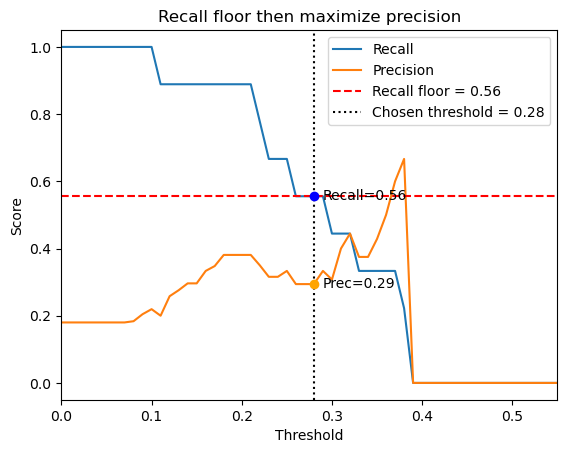

\n2. Cumulative Recall vs. Number of Alerts


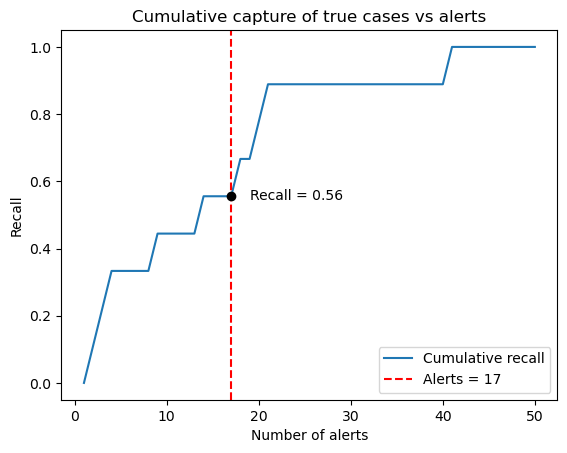

\n3. Top 30 Highest-Risk Patients View


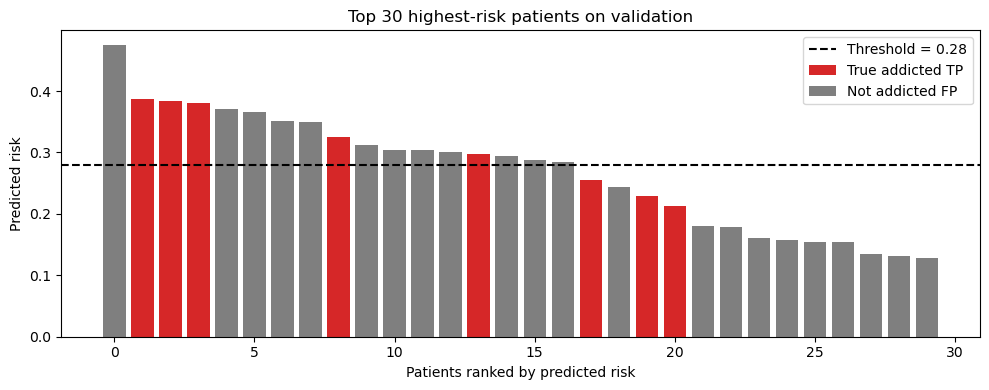

Final Calibrated Model on Test Set
PR AUC: 0.445
ROC AUC: 0.764
Prevalence p = 0.180  |  PR AUC lift = 2.47× over baseline


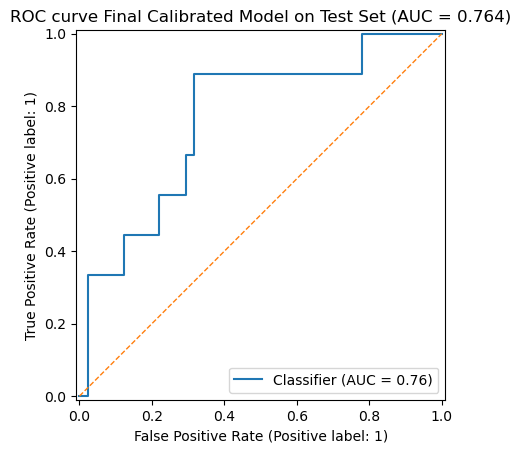

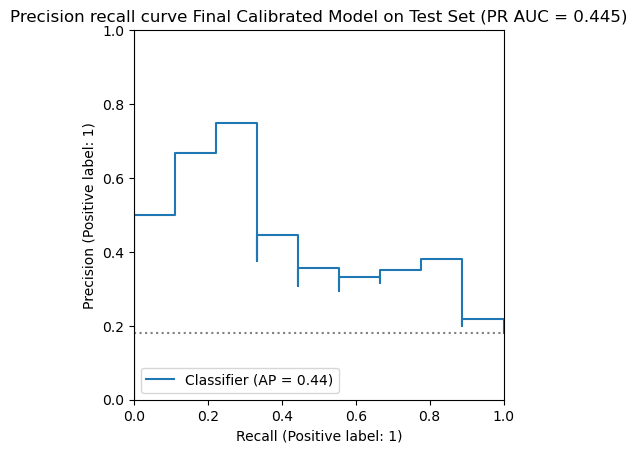

{'name': 'Final Calibrated Model on Test Set',
 'roc_auc': 0.7642276422764227,
 'pr_auc': 0.4446724308512926,
 'prevalence': 0.18,
 'lift': 2.470402393618292}

In [ ]:
from sklearn.metrics import recall_score

# --- Final Threshold Selection (from your "Recall Floor" policy) ---
# This ensures THR is set to the value derived from the validation set analysis.
THR = thr_rec

print(f"--- Visualizing Final Performance on Test Set at Threshold = {THR:.2f} ---")

# --- Step 1: Get scores and metrics on the TEST set ---
y_score_test = positive_scores(calibrated_clf, X_test)

# For the first plot, we need the actual recall achieved on the test set by our threshold.
y_pred_test = (y_score_test >= THR).astype(int)
recall_at_thr_test = recall_score(y_test, y_pred_test)


# --- Step 2: Generate the plots sequentially using your utils functions ---

# Plot 1: Recall Floor Curves
print("\\n1. Precision-Recall Curve with Final Threshold and Resulting Recall")
plot_recall_floor_curves(y_true=y_test,
                         y_score=y_score_test,
                         recall_floor=recall_at_thr_test,
                         chosen_threshold=THR)

# Plot 2: Cumulative Recall vs. Alerts
print("\\n2. Cumulative Recall vs. Number of Alerts")
plot_cumulative_recall_at_threshold(y_true=y_test,
                                     y_score=y_score_test,
                                     chosen_threshold=THR)

# Plot 3: Top-k Patient Prioritization
print("\\n3. Top 30 Highest-Risk Patients View")
plot_topk_at_threshold(y_true=y_test,
                       y_score=y_score_test,
                       chosen_threshold=THR,
                       top_k=30)

# Generate the report and plots for the final model on the test set
auc_report(y_true=y_test,
           y_score=y_score_test,
           name="Final Calibrated Model on Test Set")

# References

